<a href="https://colab.research.google.com/github/hawktao035/ISSA-Interactive_Stress_State_Analysis/blob/main/Nonlinear_UV_Transfer_Coordinate_Circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  System setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optax==0.2.4

!pip install flax==0.7.5

!pip install chex==0.1.88

!pip install orbax-checkpoint==0.4.7

!pip install scipy==1.15.1

!pip install jax==0.5.0 jax-cuda12-pjrt==0.5.0 jax-cuda12-plugin==0.5.0 jaxlib==0.5.0

!pip install pyDOE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.2/319.2 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: optax
    Found existing installation: optax 0.2.5
    Uninstalling optax-0.2.5:
      Successfully uninstalled optax-0.2.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: flax
    Found existing installation: flax 0.10.6
    Uninstalling flax-0.10.6:
      Successfully uninstalled flax-0.10.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: chex
    Found existing installation: chex 0.1.89
    Uninstalling chex-0.1.89:
      Successfully uninstalled chex-0.1.89
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: orbax-checkpoint
    Found existing installation: orbax-checkpoint 0.11.16
    Uninstalling orbax-checkpoint-0.11.16:
      Successfully uninstalled orbax-checkpoint-0.11.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import sys
import jax
import jax.numpy as jnp
import numpy as np
import optax
import abc
from jax import random, jit, vjp, grad, vmap
import jax.flatten_util as flat_utl
from tensorflow_probability.substrates import jax as tfp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from pyDOE import lhs
import functools
from scipy.io import savemat
from pathlib import Path

# change JAX to double precision
jax.config.update('jax_enable_x64', True)
rootdir = Path('/content/drive').joinpath('MyDrive')

# Customized function for collocation point arrangement
import scipy
import jax.scipy as jsp

In [ ]:
def gaussian1D_smooth(f, sig, wid):
    '''
    :param f: equally spaced 1D position matrix  (N, 1)
    :param sig: stan. devi of gaussian filter (1, ) or scalor
    :param wid: wid of the filter matrix (1, ) or scalor integer
    '''
    wid = jnp.int32(wid)
    xg = jnp.linspace(-sig, sig, wid)
    window = jsp.stats.norm.pdf(xg)
    win_n = window / jnp.sum(window)
    f_smooth = scipy.signal.convolve(f[:, 0], win_n, mode='same')[:, None]
    return f_smooth


# sample the data based on a given probability distribution
def colloc1D_set(key, x, f, Ns):
    '''
    :param x: 1-D position array (N, 1)
    :param f: 1-D distribution array (N, 1)
    :param Ns: number of points to sample
    '''
    # remove last element in each direction
    xc = x[0:-1, :]
    fc = f[0:-1, :]
    dx = xc[1] - xc[0]
    seq = jnp.arange(fc.shape[0] + 1)
    # generate key for random variables
    keys = jax.random.split(key, num=2)

    # obtain the cumulative sum of the z value
    b = jnp.hstack([0., jnp.cumsum(fc)])
    # obtain the random variable
    c = jax.random.uniform(keys[0], [Ns]) * b[-1]
    # generate the index position of each collocation point following the distribution
    # (using the interpolate the index of grid where each random variable stands)
    posi_intp = jnp.interp(c, b, seq)
    # round the result to guarantee that the index position is integer
    posi = jnp.int32(jnp.floor(posi_intp))
    # obtain the real position of each collocation point
    px = xc[posi, :]
    # generate a random fraction for each collocation point
    posi_add = jax.random.uniform(keys[1], [c.shape[0], 1])
    # add the random fraction to the position of each collocation points
    x_col = px + posi_add * dx

    return x_col


# smooth the imaging using Gaussian filter
def gaussian2D_smooth(f, sig, wid):
    '''
    :param f: equally spaced 2D position matrix [N, N]
    :param sig: stan. devi of gaussian filter (2, )
    :param wid: wid of the filter matrix (2, ) integer
    '''
    wid = jnp.int32(wid)
    xg = jnp.linspace(-sig[0], sig[0], wid[0])
    yg = jnp.linspace(-sig[1], sig[1], wid[1])
    window = jsp.stats.norm.pdf(xg) * jsp.stats.norm.pdf(yg)[:, None]
    win_n = window / jnp.sum(window)
    f_smooth = scipy.signal.convolve2d(f, win_n, mode='same')
    return f_smooth


# sample the data based on a given probability distribution
def colloc2D_set(key, X, Y, F, Ns):
    '''
    :param key: Key for random
    :param X: 2-D X position array (N, N)
    :param Y: 2-D Y position array (N, N)
    :param F: 2-D distribution array (N, N)
    :param Ns: number of points to sample
    '''

    # remove last element in each direction
    Xc = X[0:-1, 0:-1]
    Yc = Y[0:-1, 0:-1]
    Fc = F[0:-1, 0:-1]
    f = Fc.flatten()

    x = X[0, :]
    y = Y[:, 0]
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    seq = jnp.arange(f.shape[0] + 1)
    # generate key for random variables
    keys = jax.random.split(key, num=2)

    # obtain the cumulative sum of the z value
    b = jnp.hstack([0., jnp.cumsum(f)])
    # obtain the random variable
    c = jax.random.uniform(keys[0], [Ns]) * b[-1]

    # generate the index position of each collocation point following the distribution
    # (using the interpolate the index of grid where each random variable stands)
    posi_intp = jnp.interp(c, b, seq)
    # round the result to guarantee that the index position is integer
    posi_rd = jnp.floor(posi_intp)
    # obtain the 2D position of each collocation point in the position matrix
    idx_out = jnp.int32(jnp.floor(posi_rd / Fc.shape[1]))
    idx_in = jnp.int32(posi_rd % Fc.shape[1])
    # obtain the real position of each collocation point
    px = Xc[idx_out, idx_in]
    py = Yc[idx_out, idx_in]

    # generate a random fraction for each collocation point
    posi_add = jax.random.uniform(keys[1], [2, c.shape[0]])
    # add the random fraction to the position of each collocation points
    Px = px + posi_add[0] * dx
    Py = py + posi_add[1] * dy

    # group the x,y position of the collocation points into one [Nx2] matrix
    X_col = jnp.hstack((Px[:, None], Py[:, None]))

    return X_col

# Weight initialization and network architecture

In [ ]:
# initialize the neural network weights and biases
def init_MLP(parent_key, layer_widths):
    params = []
    nl = len(layer_widths) - 1
    keys = random.split(parent_key, num=nl)
    # create the weights and biases for the network
    for in_dim, out_dim, key, l in zip(layer_widths[:-1], layer_widths[1:], keys, range(nl)):
        xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
        weight_key, bias_key = random.split(key)
        params.append(
            [random.truncated_normal(weight_key, -2, 2, shape=(in_dim, out_dim)) * xavier_stddev,
             random.truncated_normal(bias_key, -2, 2, shape=(out_dim,)) * xavier_stddev]
        )
    return params


# define the basic formation of neural network
def neural_net(params, z, limit, scl, act_s):
    """
    :param params: weights and biases
    :param x: input data [matrix with shape [N, m]]; m is number of inputs)
    :param limit: characteristic scale for normalizeation [matrx with shape [2, m]]
    :param sgn:  1 for even function and -1 for odd function
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    """
    lb = limit[0]  # lower bound for each input
    ub = limit[1]  # upper bound for each input

    # choose the activation function
    actv = [jnp.tanh, jnp.sin][act_s]
    # normalize the input
    H = 2.0 * (z - lb) / (ub - lb) - 1.0
    # separate the first, hidden and last layers
    first, *hidden, last = params
    # calculate the first layers output with right scale
    H = actv(jnp.dot(H, first[0]) * scl + first[1])
    # calculate the middle layers output
    for layer in hidden:
        H = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])
    # no activation function for last layer
    var = jnp.dot(H, last[0]) + last[1]
    return var


# define sech function
def sech(z):
    return 1 / jnp.cosh(z)


# generate weights and biases for all variables of CLM problem
def sol_init_MLP(parent_key, n_hl, n_unit):
    '''
    :param n_hl: number of hidden layers [int]
    :param n_unit: number of units in each layer [int]
    '''
    layers = [2] + n_hl * [n_unit] + [2]
    # generate the random key for each network
    keys = random.split(parent_key, 1)
    # generate weights and biases for each network
    params_u = init_MLP(keys[0], layers)
    return params_u


# wrapper to create solution function with given domain size
def sol_pred_create(limit, scl, epsil, act_s):
    '''
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''

    def f_u(params, z):
        # generate the NN
        q = (1 + z[:, 0:1] ** 2 + z[:, 1:2] ** 2) ** (-1 / 2)
        beta = z[:, 0:1] ** 2 / (z[:, 0:1] ** 2 + z[:, 1:2] ** 2)
        z_qb = jnp.hstack([q, beta])
        u_NN = epsil * neural_net(params, z_qb, limit, scl, act_s)
        u = u_NN[:, 0:1] * q
        v = (z[:, 0:1] * z[:, 1:2] / (z[:, 0:1] ** 2 + z[:, 1:2] ** 2) * u_NN[:, 1:2]) * q
        uv = jnp.hstack([u, v])
        return uv

    return f_u


def mNN_pred_create(f_u, limit, scl, epsil, act_s):
    '''
    :param f_u: sum of previous stage network
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''

    def f_comb(params, z):
        # generate the NN
        q = (1 + z[:, 0:1] ** 2 + z[:, 1:2] ** 2) ** (-1 / 2)
        beta = z[:, 0:1] ** 2 / (z[:, 0:1] ** 2 + z[:, 1:2] ** 2)
        z_qb = jnp.hstack([q, beta])
        u_NN = epsil * neural_net(params, z_qb, limit, scl, act_s)
        u = f_u(z)[:, 0:1] + u_NN[:, 0:1]
        v = f_u(z)[:, 1:2] + z[:, 0:1] * z[:, 1:2] / (z[:, 0:1] ** 2 + z[:, 1:2] ** 2) * u_NN[:, 1:2]
        uv = jnp.hstack([u, v])
        return uv

    return f_comb


"""Low-level functions developed for PINN training using JAX"""


# define the mean squared error
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)


# generate matrix required for vjp for vector gradient
def vgmat(z, n_out, idx=None):
    '''
    :param n_out: number of output variables
    :param idx: indice (list) of the output variable to take the gradient
    '''
    if idx is None:
        idx = range(n_out)
    # obtain the number of index
    n_idx = len(idx)
    # obtain the number of input points
    n_pt = z.shape[0]
    # determine the shape of the gradient matrix
    mat_shape = [n_idx, n_pt, n_out]
    # create the zero matrix based on the shape
    mat = jnp.zeros(mat_shape)
    # choose the associated element in the matrix to 1
    for l, ii in zip(range(n_idx), idx):
        mat = mat.at[l, :, ii].set(1.)
    return mat


# vector gradient of the output with input
def vectgrad(func, z):
    # obtain the output and the gradient function
    sol, vjp_fn = vjp(func, z)
    # determine the mat grad
    mat = vgmat(z, sol.shape[1])
    # calculate the gradient of each output with respect to each input
    grad_sol = vmap(vjp_fn, in_axes=0)(mat)[0]
    # calculate the total partial derivative of output with input
    n_pd = z.shape[1] * sol.shape[1]
    # reshape the derivative of output with input
    grad_all = grad_sol.transpose(1, 0, 2).reshape(z.shape[0], n_pd)
    return grad_all, sol


# governing equation
def gov_eqn(f_u, z):
    u_g, u_o = vectgrad(f_u, z)

    u=u_g[:,0:1]
    v=u_g[:,1:2]

    u_x = u_g[:, 0:1]
    u_y = u_g[:, 1:2]
    v_x = u_g[:, 2:3]
    v_y = u_g[:, 3:4]

    # calculate the residue of the CCF equation
    f1 = (1 - (u ** 2) / (3.432 ** 2)) * u_x + (1 - (v ** 2) / (3.432 ** 2)) * v_y - 2 / (3.432 ** 2) * u * v * u_y
    f2 = u_y - v_x # Governing Eq. of Irrotation
    return f1, f2


def gov_deri_eqn(f_u, z):
    # allocate the value to each variable
    fc_res = lambda z: gov_eqn(f_u, z)
    # calculate the residue of higher derivative of CCF equation
    dfunc = lambda z: vectgrad(fc_res, z)[0]
    # calculate the residue of the first and second derivative of CCF equation
    df, f = vectgrad(fc_res, z)
    return df, f


def loss_create(predf_u, lw, loss_ref):
    '''
    a function factory to create the loss function based on given info
    :param loss_ref: loss value at the initial of the training
    :return: a loss function (callable)
    '''

    # loss function used for the PINN training
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        f_u = lambda z: predf_u(params, z)

        # load the data of normalization condition
        z_bd = data['cond_bd']

        # load the position and weight of collocation points
        x_col = data['x_col']
        theta = data['theta']

        # calculate the velocity at boundaries
        u_cons1 = f_u(z_bd[2])[:, 0:1]
        u_cons2 = f_u(z_bd[3])[:, 1:2]
        velocity_inf = f_u(z_bd[1])
        velocity_inner = f_u(z_bd[0])
        u_in = velocity_inner[:, 0:1]
        v_in = velocity_inner[:, 1:2]

        # calculate the mean squared root error of normalization cond.
        norm_err_inf = ms_error(velocity_inf)
        norm_err_inner = ms_error(jnp.sin(theta) * v_in + jnp.cos(theta) * (0.55 + u_in))
        norm_err_cons1 = ms_error(u_cons1 - 0.55)
        norm_err_cons2 = ms_error(u_cons2)

        # calculate the error of far-field exponent cond.
        data_err = jnp.hstack([norm_err_inf, norm_err_inner, norm_err_cons1, norm_err_cons2])

        # calculate the residue of first and second derivative
        f1, f2 = gov_eqn(f_u, x_col)
        # df, f = gov_deri_eqn(f_u, x_col)

        # calculate the mean squared root error of equation
        eqn_err_f1 = ms_error(f1)
        eqn_err_f2 = ms_error(f2)
        eqn_err = jnp.hstack([eqn_err_f1, eqn_err_f2])

        # set the weight for each condition and equation
        lw = loss_fun.lw
        lref = loss_fun.ref
        data_weight = jnp.array([1.])
        eqn_weight = jnp.array([1., lw[1]])

        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err * data_weight)
        loss_eqn = jnp.sum(eqn_err * eqn_weight)

        # calculate the total loss
        loss = (loss_data + lw[0] * loss_eqn)
        loss_n = loss / lref

        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn]),
                                data_err, eqn_err[1:], eqn_err[0]])
        return loss_n, loss_info

    loss_fun.ref = loss_ref
    loss_fun.lw = lw
    return loss_fun


# create the Adam minimizer
@functools.partial(jit, static_argnames=("lossf", "opt"))
def adam_minimizer(lossf, params, data, opt, opt_state):
    """Basic gradient update step based on the opt optimizer."""
    grads, loss_info = grad(lossf, has_aux=True)(params, data)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, loss_info, opt_state


def adam_optimizer(X_add, Y_add, lossf, predf, params, dataf, F, epoch, lr):
    # select the Adam as the minimizer
    opt_Adam = optax.adam(learning_rate=lr)
    # obtain the initial state of the params
    opt_state = opt_Adam.init(params)
    # pre-allocate the loss variable
    loss_all = []
    # set the first group of data
    key = key_adam
    data = dataf(key, F, X_add, Y_add)

    nc = jnp.int32(jnp.round(epoch / 5))
    nc0 = 2000
    # start the training iteration
    for step in range(epoch):
        # minimize the loss function using Adam
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        # print the loss for every 100 iteration
        if step % 100 == 0 and step > 0:
            # print the results
            if step % 100 == 0 and step > 0:
                print(f"Step: {step} | Loss: {loss_info[0]:.4e} |"
                      f" Loss_d: {loss_info[1]:.4e} | Loss_e: {loss_info[-1]:.4e} | ", file=sys.stderr)
            # re-sampling the data points
            key = random.split(key, 1)[0]
            data = dataf(key, F, X_add, Y_add)

            if step % 4000 == 0 and step > 0:
                qc_add = data['qc_add']
                Fs_re = F
                # plot the collocation point
                colpoint_plot(Fs_re, qc_add, [0.0, 2 ** (-1 / 2), 0.0, 1.0], ['add. collo. point', '$q$', '$beta$'])

        # saving the loss
        loss_all.append(loss_info[0:])

        if (step + 1) % nc0 == 0:
            F = predictF(predf, params, X_add, Y_add)

        if (step + 1) % (2 * nc0) == 0:
            lossend = np.array(loss_all[-2 * nc0:])[:, 0]
            lc1 = lossend[0: nc0]
            lc2 = lossend[nc0:]
            mm12 = jnp.abs(jnp.mean(lc1) - jnp.mean(lc2))
            stdl2 = jnp.std(lc2)
            # if the average loss improvement within 'nc' iteration is less than local loss fluctuation (std)
            if mm12 / stdl2 < 0.4:
                # reduce the learning rate by half
                lr = lr / 2
                opt_Adam = optax.adam(learning_rate=lr)
            print(f"learning rate for Adam: {lr:.4e} | mean: {mm12:.3e} | std: {stdl2:.3e}", file=sys.stderr)

    # obtain the total loss in the last iterations
    lossend = jnp.array(loss_all[-nc:])[:, 0]
    # find the minimum loss value
    lmin = jnp.min(lossend)
    # optain the last loss value
    llast = lossend[-1]
    # guarantee the loss value in last iteration is smaller than anyone before
    for lc in range(2 * nc0):
        if llast < lmin:
            break
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        llast = loss_info[0]
        # saving the loss
        loss_all.append(loss_info[0:])

    print(f"Step: {step} | Loss: {loss_info[0]:.4e} |"
          f" Loss_d: {loss_info[1]:.4e} | Loss_e: {loss_info[-1]:.4e} | ", file=sys.stderr)
    return params, loss_all


# A factory to create a function required by tfp.optimizer.lbfgs_minimize.
def lbfgs_function(lossf, init_params, data):
    # obtain the 1D parameters and the function that can turn back to the pytree
    _, unflat = flat_utl.ravel_pytree(init_params)

    def update(params_1d):
        # updating the model's parameters from the 1D array
        params = unflat(params_1d)
        return params

    # A function that can be used by tfp.optimizer.lbfgs_minimize.
    @jit
    def f(params_1d):
        # convert the 1d parameters back to pytree format
        params = update(params_1d)
        # calculate gradients and convert to 1D tf.Tensor
        grads, loss_info = grad(lossf, has_aux=True)(params, data)
        # convert the grad to 1d arrays
        grads_1d = flat_utl.ravel_pytree(grads)[0]
        loss_value = loss_info[0]

        # # store loss value so we can retrieve later
        jax.debug.callback(lambda x: f.loss.append(x), loss_info[0:])
        jax.debug.callback(lambda x: print(f"Step: NaN | Loss: {x[0]:.4e} |"
                                           f" Loss_d: {x[1]:.4e} | Loss_e: {x[-1]:.4e}"),
                           loss_info)

        return loss_value, grads_1d

    # store these information as members so we can use them outside the scope
    f.update = update
    f.loss = []
    return f


# define the function to apply the L-BFGS optimizer
def lbfgs_optimizer(lossf, params, data, epoch):
    func_lbfgs = lbfgs_function(lossf, params, data)
    # convert initial model parameters to a 1D array
    init_params_1d = flat_utl.ravel_pytree(params)[0]
    # calculate the effective number of iteration
    max_nIter = jnp.int32(epoch / 3)
    # train the model with L-BFGS solver
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=func_lbfgs, initial_position=init_params_1d,
        tolerance=1e-10, max_iterations=max_nIter)
    params = func_lbfgs.update(results.position)
    # history = func_lbfgs.loss
    num_iter = results.num_objective_evaluations
    loss_all = func_lbfgs.loss
    print(f" Total iterations: {num_iter}")
    return params, loss_all

# Dynamic data sampling

In [ ]:
def data_func_create(N_col, N_bd, mode_cbd):
    q = jnp.linspace(1e-16, 2 ** (-1 / 2), 111)
    beta = jnp.linspace(0, 1, 111)
    F_bd = data_sampling(Q, BETA, mode_cbd)

    # define the function that can re-sampling for each calling
    def dataf(key, F_add, Q_add, BETA_add):
        keys = random.split(key, 2)

        # set the initial and boundary conditions

        # 1. Inner circle
        theta = lhs(1, N_bd) * jnp.array([jnp.pi / 2])
        x1 = jnp.cos(theta)
        y1 = jnp.sin(theta)
        xy1 = jnp.hstack([x1, y1])

        # 2. Infinite
        qb2 = lhs(2, N_bd) * jnp.array([0, 1]) + jnp.array([1e-16, 0])
        x2 = jnp.sqrt(qb2[:, 1:2] * (1 / qb2[:, 0:1] ** 2 - 1))
        y2 = jnp.sqrt((1 - qb2[:, 1:2]) * (1 / qb2[:, 0:1] ** 2 - 1))
        xy2 = jnp.hstack([x2, y2])

        # 3. Constraint (e.g., stagnation point)
        theta1 = jnp.array([[jnp.pi / 2]])
        x3 = jnp.cos(theta1)
        y3 = jnp.sin(theta1)
        xy3 = jnp.hstack([x3, y3])

        theta2 = jnp.array([[0]])
        x4 = jnp.cos(theta1)
        y4 = jnp.sin(theta1)
        xy4 = jnp.hstack([x4, y4])

        # group the initial and boundary conditions
        x_bd = [xy1, xy2, xy3, xy4]

        # prepare the collocation points
        # 1. collocation point
        qb_col = lhs(2, N_col[0]) * jnp.array([2 ** (-1 / 2), 1])
        qb_col = qb_col.at[:, 0:1].set(jnp.maximum(qb_col[:, 0:1], 1e-16))
        x_col = jnp.sqrt(qb_col[:, 1:2] * (1 / qb_col[:, 0:1] ** 2 - 1))
        y_col = jnp.sqrt((1 - qb_col[:, 1:2]) * (1 / qb_col[:, 0:1] ** 2 - 1))
        xy_col = jnp.hstack([x_col, y_col])

        # 2. boundary point
        qc_bd = colloc2D_set(keys[0], Q, BETA, F_bd, N_col[1])
        qc_bd = qc_bd.at[:, 0:1].set(jnp.maximum(qc_bd[:, 0:1], 1e-16))
        xc_bd = jnp.sqrt(qc_bd[:, 1:2] * (1 / qc_bd[:, 0:1] ** 2 - 1))
        yc_bd = jnp.sqrt((1 - qc_bd[:, 1:2]) * (1 / qc_bd[:, 0:1] ** 2 - 1))
        xyc_bd = jnp.hstack([xc_bd, yc_bd])

        # 3. adaptive point
        qc_add = colloc2D_set(keys[1], Q_add, BETA_add, F_add, N_col[2])
        qc_add = qc_add.at[:, 0:1].set(jnp.maximum(qc_add[:, 0:1], 1e-16))
        xc_add = jnp.sqrt(qc_add[:, 1:2] * (1 / qc_add[:, 0:1] ** 2 - 1))
        yc_add = jnp.sqrt((1 - qc_add[:, 1:2]) * (1 / qc_add[:, 0:1] ** 2 - 1))
        xyc_add = jnp.hstack([xc_add, yc_add])

        # add the collocation at the boundary region
        z_col = jnp.vstack([xy_col, xyc_bd, jnp.vstack(x_bd), xyc_add])

        q_col = (1 + z_col[:, 0:1] ** 2 + z_col[:, 1:2] ** 2) ** (-1 / 2)
        beta_col = z_col[:, 0:1] ** 2 / (z_col[:, 0:1] ** 2 + z_col[:, 1:2] ** 2)
        q_col = jnp.hstack([q_col, beta_col])

        # group all the conditions and collocation points
        data = dict(x_col=z_col, theta=theta, q_col=q_col, qc_add=qc_add, cond_bd=x_bd)
        return data

    return dataf


# plot the collocation point
def colpoint_plot(U, X_col, limit1, fig_str):
    # limit = [x1min, x1max, x1min, x2max]
    # limit2= [xmin, xmax, ymin, ymax] OR []
    # fig_str = ['title', 'xlabel', 'yabel']

    fig = plt.figure(figsize=[12, 10], dpi=100)

    ax = plt.subplot()

    h = ax.imshow(U, interpolation='nearest', cmap='rainbow',
                  extent=limit1, origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_col[:, 0], X_col[:, 1], 'kx', markersize=5, clip_on=False)
    ax.set_title(fig_str[0], fontsize=15)
    ax.set_xlabel(fig_str[1], fontsize=15)
    ax.set_ylabel(fig_str[2], fontsize=15, rotation=0)
    plt.show()


def predictF(predf, params, z1, z2):
    # create the output function
    fsol = lambda z: predf(params, z)
    # generate the input for network
    x_star = jnp.sqrt(z2 * (1 / z1 ** 2 - 1))
    y_star = jnp.sqrt((1 - z2) * (1 / z1 ** 2 - 1))
    z_star = jnp.hstack((x_star.flatten()[:, None], y_star.flatten()[:, None]))
    mask = (z1 < 0) | (z1 > 2 ** (-1 / 2)) | (z2 < 0) | (z2 > 1)
    # calculate the equation residue
    f0 = gov_eqn(fsol, z_star)[0]
    # calculate the maximum of the square of residue for all equations
    f_sq = f0 ** 2
    # normalize the distribution function and add a basic level
    f_nm = f_sq / jnp.mean(f_sq) + 0.1
    # create the 2D distribution function F
    F = jnp.reshape(f_nm, z1.shape)
    F = jnp.where(mask, 0.0, F)
    # smooth the weight function by Gaussian filter
    Fs = gaussian2D_smooth(F, [1, 1], [5, 5])

    return Fs


def data_sampling(Q, BETA, mode):
    if mode == 1:
        F = jnp.where((BETA >= 0) & (BETA <= 1) & (Q >= 0.0) & (Q <= 0.3), 1.0, 0.0)

    if mode == 2:
        F = jnp.where((BETA >= 0) & (BETA <= 1) & (Q >= 0.6) & (Q <= 2 ** (-1 / 2)), 1.0, 0.0)

    return F

# Problem setup


In [ ]:
"""Set the conditions of the problem"""
# select the random seed
seed = 1234
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 10)

"""loading the dataset and define the domain"""

q = jnp.linspace(1e-16, 2 ** (-1 / 2), 111)
beta = jnp.linspace(0, 1, 111)

Q, BETA = jnp.meshgrid(q, beta)
X = jnp.sqrt(BETA * (1 / Q ** 2 - 1))
Y = jnp.sqrt((1 - BETA) * (1 / Q ** 2 - 1))
X_star = jnp.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Domain bounds
lb = jnp.array([0.0, 0.0])
ub = jnp.array([2 ** (-1 / 2), 1.0])
limit = [lb, ub]

# 1st stage neural network

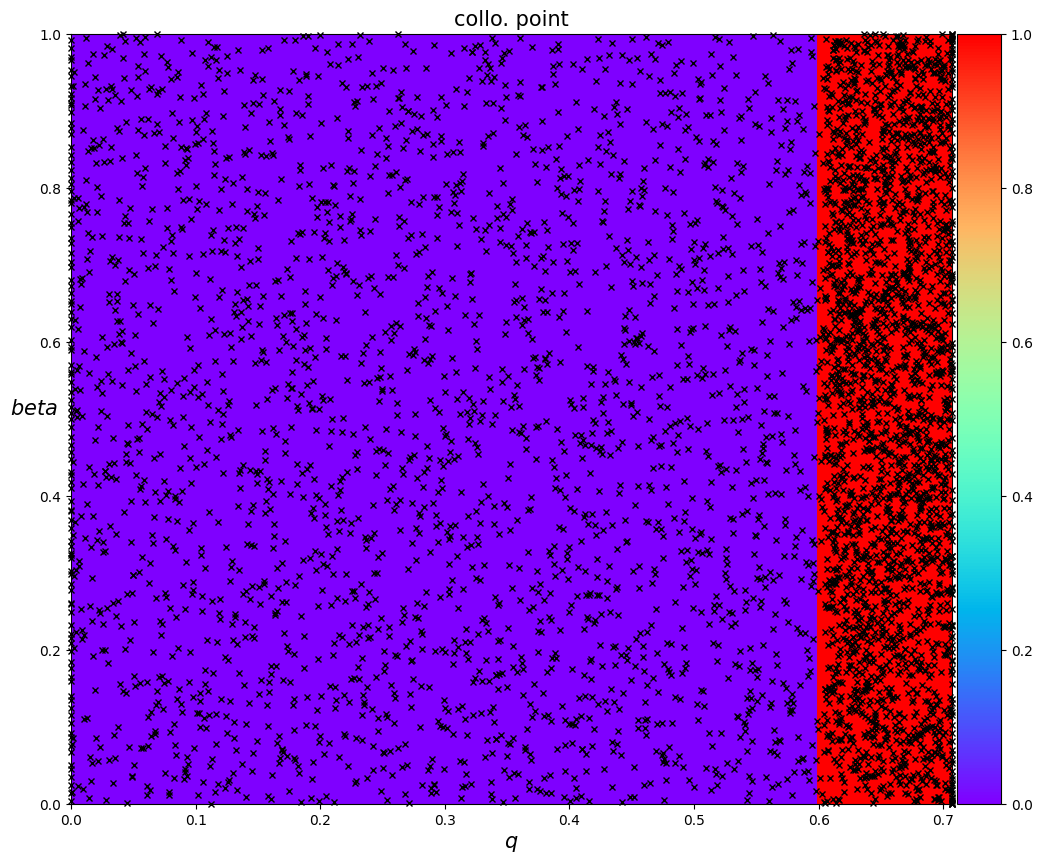

In [ ]:
# select the size of neural network
n_hl1 = 6
n_unit1 = 60
scl1 = 1
epsil1 = 1

# number of sampling points (x_col, x_bd, x_add)
N_col = jnp.array([3000, 1000, 1000])
N_bd = 100

# initialize the weights and biases of the network
trained_params1 = sol_init_MLP(keys[0], n_hl1, n_unit1)

# set the training iteration
lw1 = jnp.array([0.1, 1])

# create the solution function (act_s: tan-0, sin-1)
pred_u1 = sol_pred_create(limit, scl1, epsil1, act_s=0)

# create the data function
dataf1 = data_func_create(N_col, N_bd, mode_cbd=2)
Fs=data_sampling(Q,BETA,mode=2)
key_adam = keys[1]
key_lbfgs = random.split(keys[2], 1)
data1 = dataf1(key_adam, Fs, Q, BETA)

# plot the collocation point
plot = 1
if plot == 1:
    q_c = data1['q_col']
    colpoint_plot(Fs, q_c, [0.0, 2 ** (-1 / 2), -0.0, 1.0], ['collo. point', '$q$', '$beta$'])

# calculate the loss function
NN_loss = loss_create(pred_u1, lw1, loss_ref=1)
NN_loss.ref = NN_loss(trained_params1, data1)[1][0]

Step: 100 | Loss: 5.0191e-03 | Loss_d: 5.2829e-04 | Loss_e: 2.2879e-02 | 
Step: 200 | Loss: 2.1143e-03 | Loss_d: 1.5718e-04 | Loss_e: 7.3488e-03 | 
Step: 300 | Loss: 5.7601e-04 | Loss_d: 1.5171e-05 | Loss_e: 2.8112e-03 | 
Step: 400 | Loss: 1.9819e-04 | Loss_d: 7.0541e-06 | Loss_e: 1.1664e-03 | 
Step: 500 | Loss: 8.4290e-05 | Loss_d: 4.9528e-06 | Loss_e: 4.9485e-04 | 
Step: 600 | Loss: 4.3111e-05 | Loss_d: 3.7720e-06 | Loss_e: 2.4240e-04 | 
Step: 700 | Loss: 3.1277e-05 | Loss_d: 3.0693e-06 | Loss_e: 1.8527e-04 | 
Step: 800 | Loss: 2.5065e-05 | Loss_d: 2.4091e-06 | Loss_e: 1.5556e-04 | 
Step: 900 | Loss: 2.3438e-05 | Loss_d: 2.4533e-06 | Loss_e: 1.4634e-04 | 
Step: 1000 | Loss: 2.0021e-05 | Loss_d: 1.8325e-06 | Loss_e: 1.2602e-04 | 
Step: 1100 | Loss: 2.7690e-05 | Loss_d: 9.6882e-06 | Loss_e: 1.2245e-04 | 
Step: 1200 | Loss: 1.6547e-05 | Loss_d: 1.4472e-06 | Loss_e: 1.0088e-04 | 
Step: 1300 | Loss: 4.5298e-04 | Loss_d: 4.3315e-04 | Loss_e: 1.1932e-04 | 
Step: 1400 | Loss: 1.5305e-05 | Lo

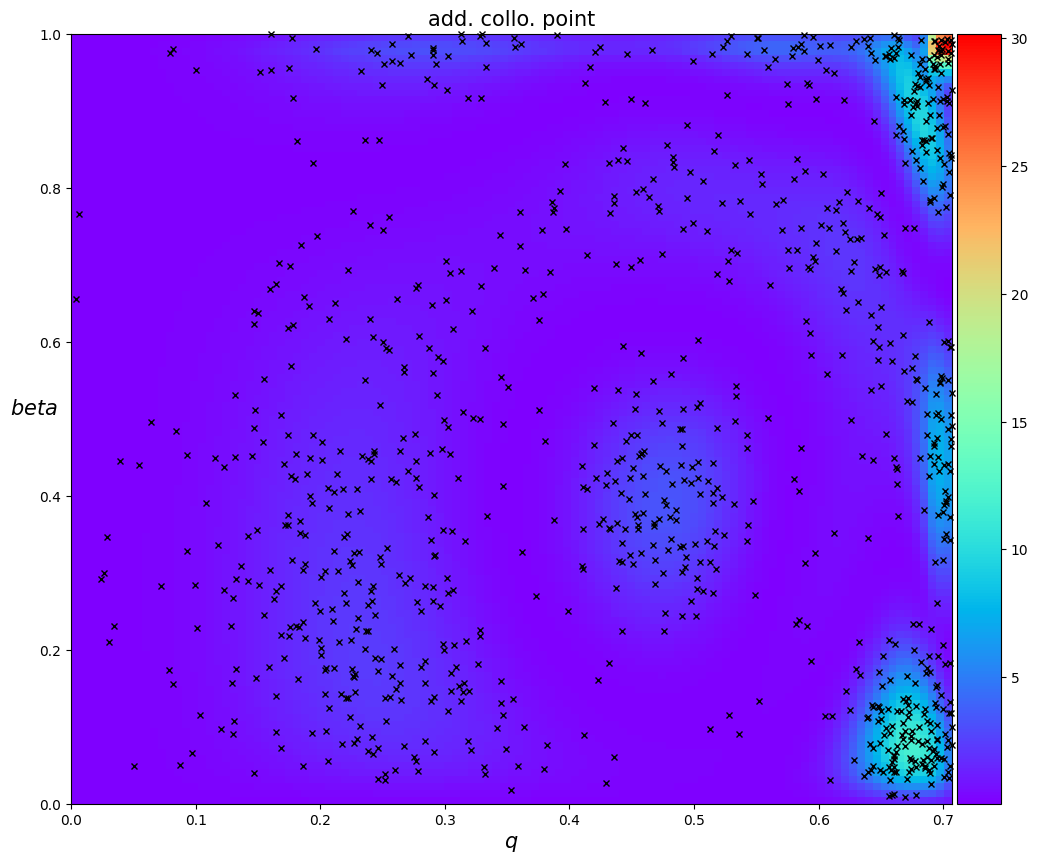

Step: 4100 | Loss: 3.7633e-06 | Loss_d: 8.0830e-07 | Loss_e: 1.2913e-05 | 
Step: 4200 | Loss: 1.4876e-05 | Loss_d: 1.2283e-05 | Loss_e: 1.1065e-05 | 
Step: 4300 | Loss: 4.8687e-06 | Loss_d: 1.1340e-06 | Loss_e: 1.5690e-05 | 
Step: 4400 | Loss: 3.5709e-06 | Loss_d: 7.2915e-07 | Loss_e: 1.1869e-05 | 
Step: 4500 | Loss: 3.0632e-06 | Loss_d: 6.0921e-07 | Loss_e: 9.6004e-06 | 
Step: 4600 | Loss: 5.4114e-06 | Loss_d: 1.2163e-06 | Loss_e: 1.7329e-05 | 
Step: 4700 | Loss: 3.5816e-06 | Loss_d: 7.6554e-07 | Loss_e: 1.1320e-05 | 
Step: 4800 | Loss: 3.0348e-06 | Loss_d: 5.8520e-07 | Loss_e: 9.0402e-06 | 
Step: 4900 | Loss: 6.2005e-06 | Loss_d: 2.1670e-06 | Loss_e: 1.6112e-05 | 
Step: 5000 | Loss: 3.4561e-06 | Loss_d: 7.0117e-07 | Loss_e: 1.0752e-05 | 
Step: 5100 | Loss: 2.9594e-06 | Loss_d: 5.4473e-07 | Loss_e: 9.0563e-06 | 
Step: 5200 | Loss: 8.3949e-06 | Loss_d: 2.9998e-06 | Loss_e: 2.3758e-05 | 
Step: 5300 | Loss: 3.8371e-06 | Loss_d: 8.1890e-07 | Loss_e: 1.2136e-05 | 
Step: 5400 | Loss: 3.0939

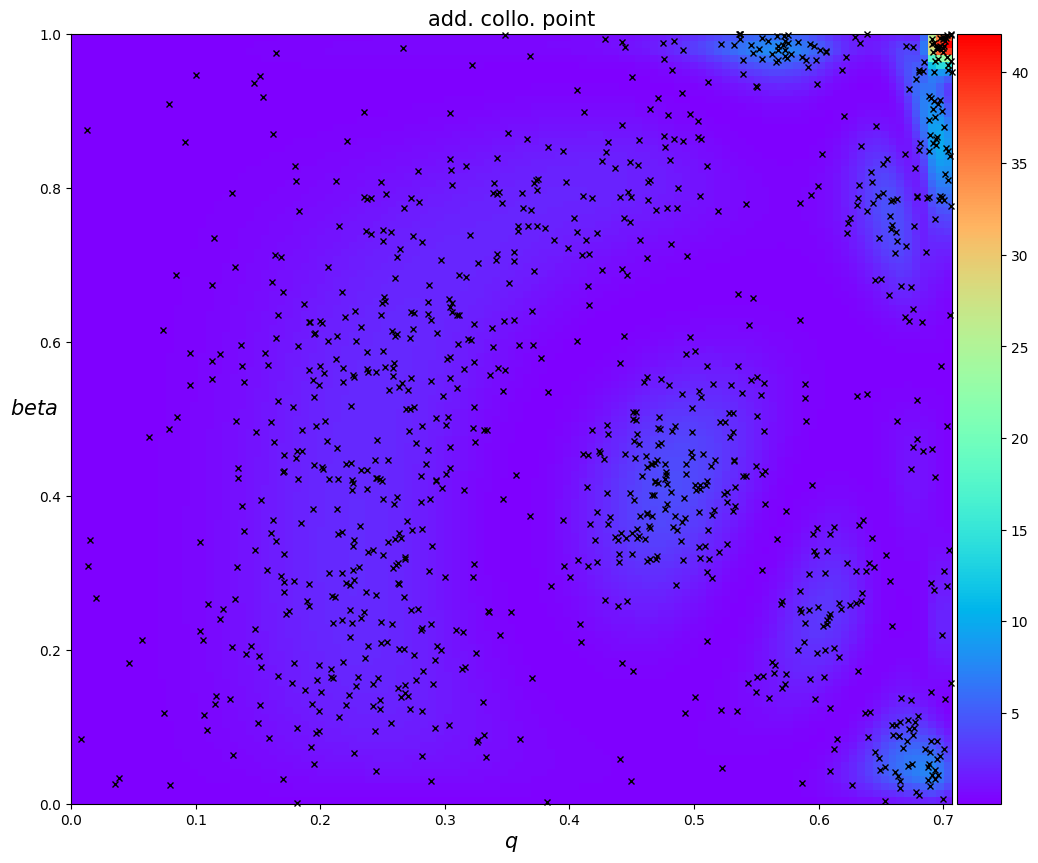

Step: 8100 | Loss: 2.2923e-06 | Loss_d: 3.6102e-07 | Loss_e: 6.7715e-06 | 
Step: 8200 | Loss: 2.1817e-06 | Loss_d: 3.4411e-07 | Loss_e: 6.2711e-06 | 
Step: 8300 | Loss: 2.0503e-06 | Loss_d: 3.1286e-07 | Loss_e: 5.7627e-06 | 
Step: 8400 | Loss: 1.9653e-06 | Loss_d: 3.0643e-07 | Loss_e: 5.6776e-06 | 
Step: 8500 | Loss: 1.9333e-06 | Loss_d: 3.1031e-07 | Loss_e: 5.5393e-06 | 
Step: 8600 | Loss: 1.8638e-06 | Loss_d: 2.9155e-07 | Loss_e: 5.1948e-06 | 
Step: 8700 | Loss: 1.7611e-06 | Loss_d: 2.6896e-07 | Loss_e: 4.8572e-06 | 
Step: 8800 | Loss: 1.7252e-06 | Loss_d: 2.6063e-07 | Loss_e: 4.7915e-06 | 
Step: 8900 | Loss: 1.6425e-06 | Loss_d: 2.4881e-07 | Loss_e: 4.5029e-06 | 
Step: 9000 | Loss: 1.6099e-06 | Loss_d: 2.6331e-07 | Loss_e: 4.3183e-06 | 
Step: 9100 | Loss: 1.5770e-06 | Loss_d: 2.3591e-07 | Loss_e: 4.3545e-06 | 
Step: 9200 | Loss: 1.5119e-06 | Loss_d: 2.2944e-07 | Loss_e: 4.0866e-06 | 
Step: 9300 | Loss: 2.5077e-06 | Loss_d: 1.0697e-06 | Loss_e: 4.8022e-06 | 
Step: 9400 | Loss: 1.5179

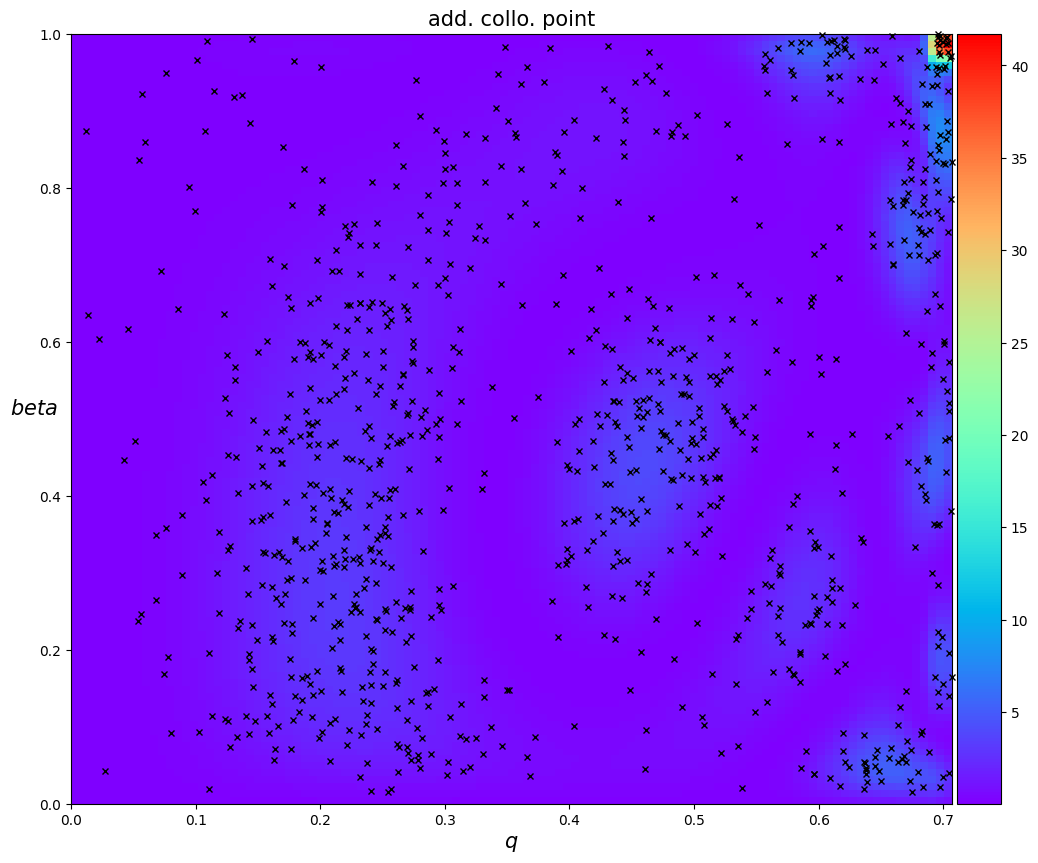

Step: 12100 | Loss: 1.0661e-06 | Loss_d: 1.3240e-07 | Loss_e: 2.8968e-06 | 
Step: 12200 | Loss: 1.0568e-06 | Loss_d: 1.3320e-07 | Loss_e: 2.9669e-06 | 
Step: 12300 | Loss: 1.0097e-06 | Loss_d: 1.2656e-07 | Loss_e: 2.8752e-06 | 
Step: 12400 | Loss: 9.8928e-07 | Loss_d: 1.1593e-07 | Loss_e: 2.7942e-06 | 
Step: 12500 | Loss: 9.7123e-07 | Loss_d: 1.2300e-07 | Loss_e: 2.6339e-06 | 
Step: 12600 | Loss: 9.5571e-07 | Loss_d: 1.2121e-07 | Loss_e: 2.5823e-06 | 
Step: 12700 | Loss: 9.1824e-07 | Loss_d: 1.1365e-07 | Loss_e: 2.4050e-06 | 
Step: 12800 | Loss: 8.7031e-07 | Loss_d: 1.1011e-07 | Loss_e: 2.3395e-06 | 
Step: 12900 | Loss: 8.7347e-07 | Loss_d: 1.0704e-07 | Loss_e: 2.3325e-06 | 
Step: 13000 | Loss: 8.4389e-07 | Loss_d: 1.0349e-07 | Loss_e: 2.2093e-06 | 
Step: 13100 | Loss: 8.2319e-07 | Loss_d: 1.0071e-07 | Loss_e: 2.1683e-06 | 
Step: 13200 | Loss: 7.9658e-07 | Loss_d: 9.6311e-08 | Loss_e: 2.1290e-06 | 
Step: 13300 | Loss: 9.2730e-06 | Loss_d: 8.4289e-06 | Loss_e: 2.9289e-06 | 
Step: 13400 

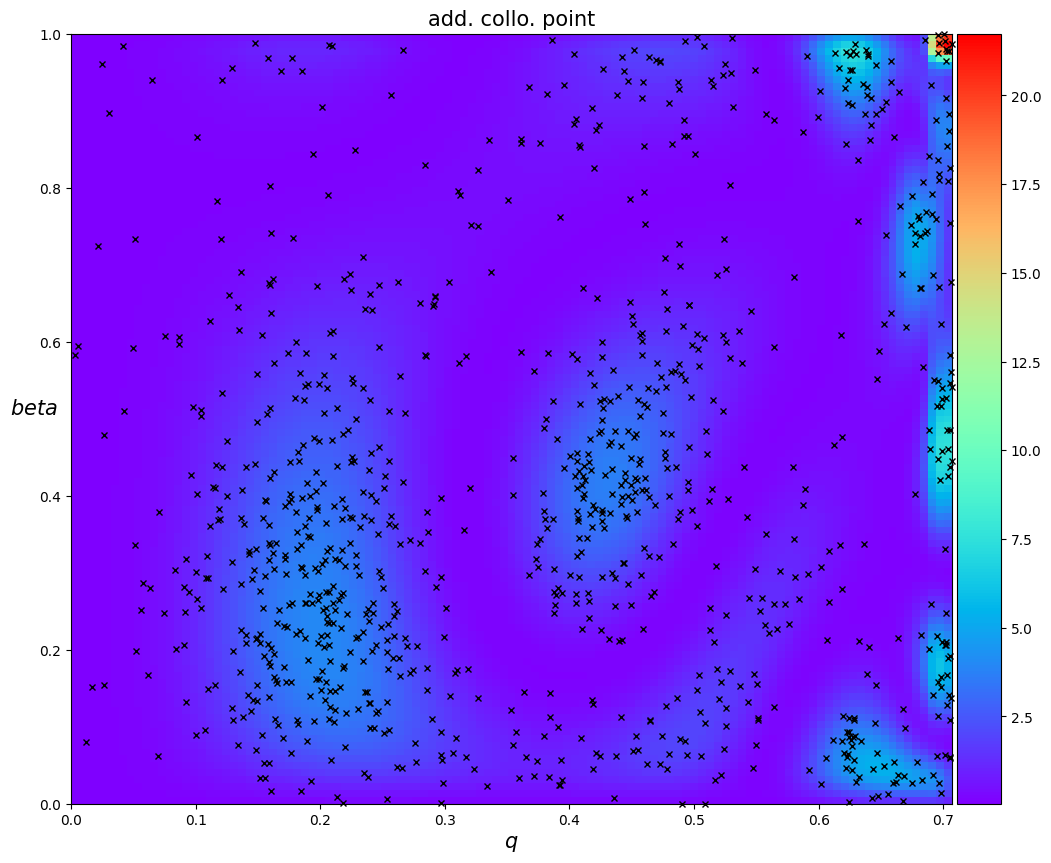

Step: 16100 | Loss: 4.7949e-07 | Loss_d: 4.9621e-08 | Loss_e: 1.4231e-06 | 
Step: 16200 | Loss: 4.6783e-07 | Loss_d: 4.7517e-08 | Loss_e: 1.3834e-06 | 
Step: 16300 | Loss: 4.5989e-07 | Loss_d: 4.9674e-08 | Loss_e: 1.3244e-06 | 
Step: 16400 | Loss: 4.5307e-07 | Loss_d: 4.7294e-08 | Loss_e: 1.3182e-06 | 
Step: 16500 | Loss: 4.4695e-07 | Loss_d: 4.5388e-08 | Loss_e: 1.3021e-06 | 
Step: 16600 | Loss: 4.2997e-07 | Loss_d: 4.3256e-08 | Loss_e: 1.2971e-06 | 
Step: 16700 | Loss: 4.2288e-07 | Loss_d: 4.1408e-08 | Loss_e: 1.2192e-06 | 
Step: 16800 | Loss: 4.2103e-07 | Loss_d: 4.3303e-08 | Loss_e: 1.2251e-06 | 
Step: 16900 | Loss: 4.0210e-07 | Loss_d: 4.0571e-08 | Loss_e: 1.2020e-06 | 
Step: 17000 | Loss: 3.9216e-07 | Loss_d: 3.9737e-08 | Loss_e: 1.1572e-06 | 
Step: 17100 | Loss: 3.9034e-07 | Loss_d: 3.7628e-08 | Loss_e: 1.1731e-06 | 
Step: 17200 | Loss: 3.7806e-07 | Loss_d: 3.8697e-08 | Loss_e: 1.1414e-06 | 
Step: 17300 | Loss: 3.6503e-07 | Loss_d: 3.5907e-08 | Loss_e: 1.1226e-06 | 
Step: 17400 

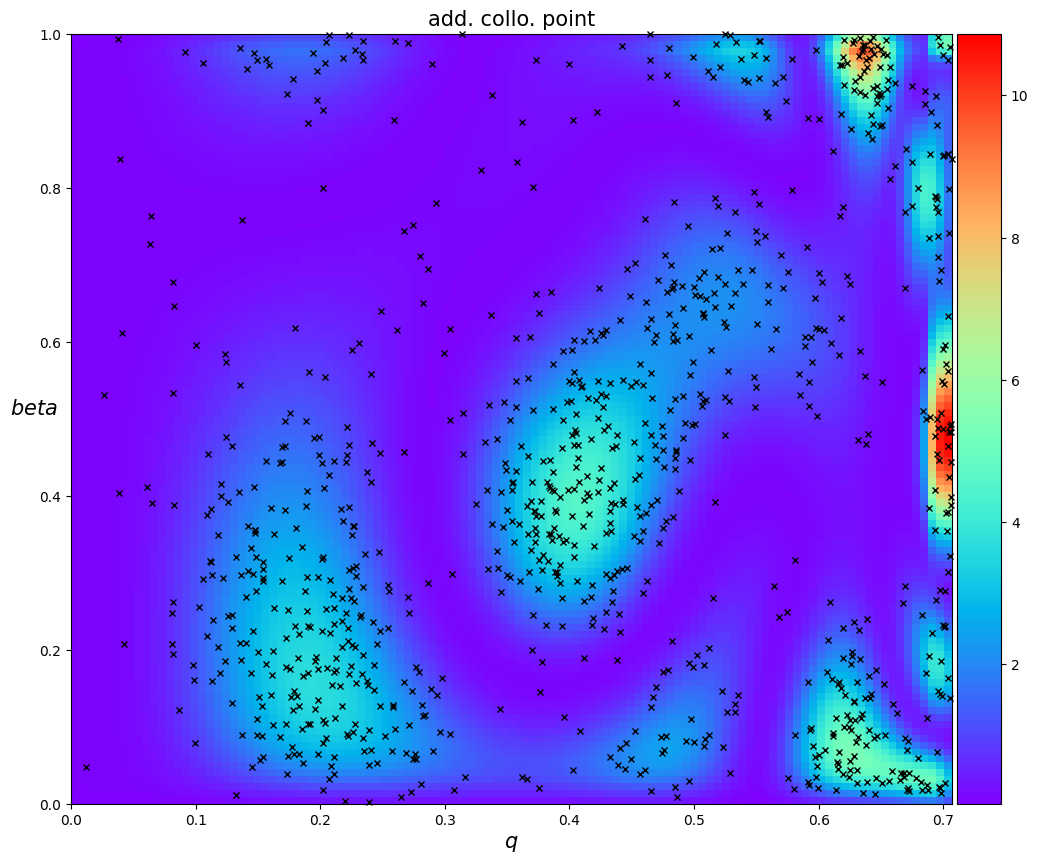

Step: 20100 | Loss: 2.3300e-07 | Loss_d: 2.2327e-08 | Loss_e: 8.1123e-07 | 
Step: 20200 | Loss: 2.3179e-07 | Loss_d: 2.1720e-08 | Loss_e: 7.9913e-07 | 
Step: 20300 | Loss: 2.2707e-07 | Loss_d: 2.0872e-08 | Loss_e: 7.9374e-07 | 
Step: 20400 | Loss: 2.2876e-07 | Loss_d: 2.0473e-08 | Loss_e: 7.8754e-07 | 
Step: 20500 | Loss: 2.2743e-07 | Loss_d: 2.1563e-08 | Loss_e: 7.9056e-07 | 
Step: 20600 | Loss: 2.2336e-07 | Loss_d: 2.0692e-08 | Loss_e: 7.6273e-07 | 
Step: 20700 | Loss: 2.2078e-07 | Loss_d: 2.1205e-08 | Loss_e: 7.7177e-07 | 
Step: 20800 | Loss: 2.1971e-07 | Loss_d: 2.1091e-08 | Loss_e: 7.6052e-07 | 
Step: 20900 | Loss: 2.2031e-07 | Loss_d: 2.1020e-08 | Loss_e: 7.7606e-07 | 
Step: 21000 | Loss: 2.1731e-07 | Loss_d: 2.0236e-08 | Loss_e: 7.6666e-07 | 
Step: 21100 | Loss: 2.1338e-07 | Loss_d: 1.9756e-08 | Loss_e: 7.4833e-07 | 
Step: 21200 | Loss: 2.0923e-07 | Loss_d: 1.9229e-08 | Loss_e: 7.3977e-07 | 
Step: 21300 | Loss: 2.0696e-07 | Loss_d: 1.9306e-08 | Loss_e: 7.4526e-07 | 
Step: 21400 

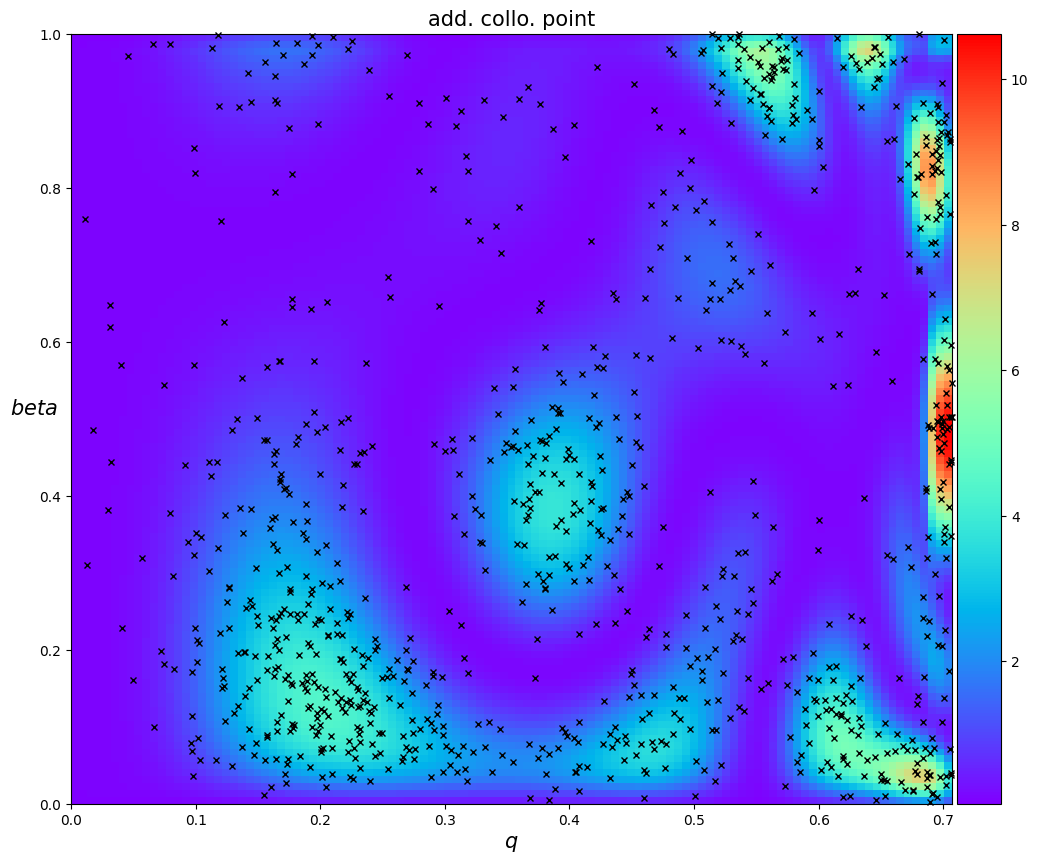

Step: 24100 | Loss: 1.6377e-07 | Loss_d: 1.3670e-08 | Loss_e: 6.2249e-07 | 
Step: 24200 | Loss: 1.5924e-07 | Loss_d: 1.3120e-08 | Loss_e: 6.0871e-07 | 
Step: 24300 | Loss: 1.5975e-07 | Loss_d: 1.3371e-08 | Loss_e: 5.9832e-07 | 
Step: 24400 | Loss: 1.5872e-07 | Loss_d: 1.3782e-08 | Loss_e: 6.0060e-07 | 
Step: 24500 | Loss: 1.5598e-07 | Loss_d: 1.3046e-08 | Loss_e: 5.9244e-07 | 
Step: 24600 | Loss: 1.5621e-07 | Loss_d: 1.3380e-08 | Loss_e: 5.9442e-07 | 
Step: 24700 | Loss: 1.5700e-07 | Loss_d: 1.3410e-08 | Loss_e: 6.0381e-07 | 
Step: 24800 | Loss: 1.5289e-07 | Loss_d: 1.2723e-08 | Loss_e: 6.0044e-07 | 
Step: 24900 | Loss: 1.5470e-07 | Loss_d: 1.3085e-08 | Loss_e: 5.8815e-07 | 
Step: 25000 | Loss: 1.5152e-07 | Loss_d: 1.3109e-08 | Loss_e: 5.7123e-07 | 
Step: 25100 | Loss: 1.5203e-07 | Loss_d: 1.3089e-08 | Loss_e: 5.7882e-07 | 
Step: 25200 | Loss: 1.4976e-07 | Loss_d: 1.2902e-08 | Loss_e: 5.6422e-07 | 
Step: 25300 | Loss: 1.4712e-07 | Loss_d: 1.2195e-08 | Loss_e: 5.6968e-07 | 
Step: 25400 

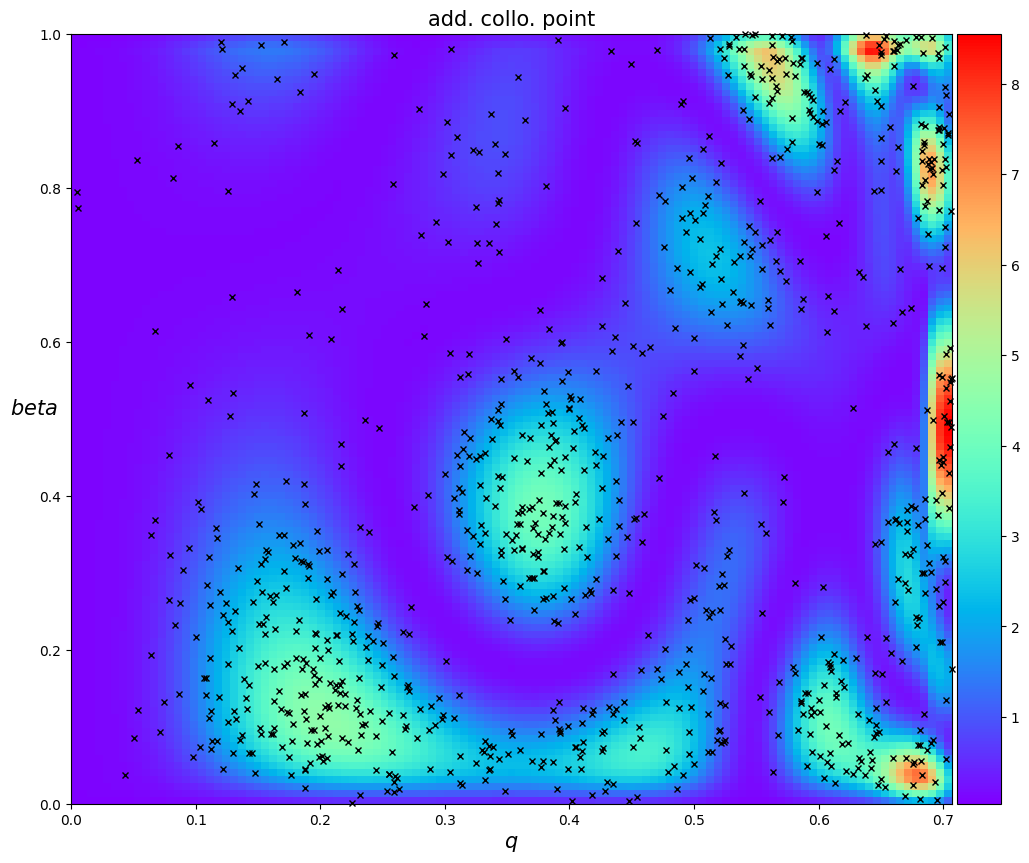

Step: 28100 | Loss: 1.2403e-07 | Loss_d: 9.4192e-09 | Loss_e: 4.7786e-07 | 
Step: 28200 | Loss: 1.2360e-07 | Loss_d: 9.6014e-09 | Loss_e: 4.7299e-07 | 
Step: 28300 | Loss: 1.2145e-07 | Loss_d: 9.2335e-09 | Loss_e: 4.6851e-07 | 
Step: 28400 | Loss: 1.2158e-07 | Loss_d: 9.7231e-09 | Loss_e: 4.7445e-07 | 
Step: 28500 | Loss: 1.2189e-07 | Loss_d: 9.1167e-09 | Loss_e: 4.7235e-07 | 
Step: 28600 | Loss: 1.2024e-07 | Loss_d: 9.1374e-09 | Loss_e: 4.7111e-07 | 
Step: 28700 | Loss: 1.2102e-07 | Loss_d: 9.3039e-09 | Loss_e: 4.5833e-07 | 
Step: 28800 | Loss: 1.1886e-07 | Loss_d: 8.9431e-09 | Loss_e: 4.5967e-07 | 
Step: 28900 | Loss: 1.1963e-07 | Loss_d: 9.2090e-09 | Loss_e: 4.6659e-07 | 
Step: 29000 | Loss: 1.2122e-07 | Loss_d: 9.1883e-09 | Loss_e: 4.7068e-07 | 
Step: 29100 | Loss: 1.1771e-07 | Loss_d: 8.9427e-09 | Loss_e: 4.5490e-07 | 
Step: 29200 | Loss: 1.1809e-07 | Loss_d: 9.0310e-09 | Loss_e: 4.5029e-07 | 
Step: 29300 | Loss: 1.1653e-07 | Loss_d: 8.9474e-09 | Loss_e: 4.5651e-07 | 
Step: 29400 

In [ ]:
"""Training using Adam"""

# set the learning rate for Adam
lr = 1e-3
epoch1 = 30000
trained_params1, loss11 = adam_optimizer(Q, BETA, NN_loss, pred_u1, trained_params1, dataf1, Fs, epoch1, lr=lr)
Fs = predictF(pred_u1, trained_params1, Q, BETA)
data1 = dataf1(key_lbfgs[0], Fs, Q, BETA)

In [ ]:
"""Training using L-BFGS"""

loss12 = []
epoch2 = 7000
for l in range(2):
    trained_params1, loss = lbfgs_optimizer(NN_loss, trained_params1, data1, epoch2)
    Fs = predictF(pred_u1, trained_params1, Q, BETA)
    data1 = dataf1(key_lbfgs[l], Fs, Q, BETA)
    loss12 += loss

流式输出内容被截断，只能显示最后 5000 行内容。
Step: NaN | Loss: 1.9458e-08 | Loss_d: 7.4444e-10 | Loss_e: 8.1364e-08
Step: NaN | Loss: 1.9474e-08 | Loss_d: 7.7647e-10 | Loss_e: 8.1283e-08
Step: NaN | Loss: 1.9455e-08 | Loss_d: 7.4990e-10 | Loss_e: 8.1322e-08
Step: NaN | Loss: 1.9454e-08 | Loss_d: 7.5013e-10 | Loss_e: 8.1306e-08
Step: NaN | Loss: 1.9455e-08 | Loss_d: 7.5382e-10 | Loss_e: 8.1261e-08
Step: NaN | Loss: 1.9453e-08 | Loss_d: 7.5091e-10 | Loss_e: 8.1287e-08
Step: NaN | Loss: 1.9451e-08 | Loss_d: 7.4770e-10 | Loss_e: 8.1335e-08
Step: NaN | Loss: 1.9455e-08 | Loss_d: 7.3685e-10 | Loss_e: 8.1606e-08
Step: NaN | Loss: 1.9450e-08 | Loss_d: 7.4405e-10 | Loss_e: 8.1405e-08
Step: NaN | Loss: 1.9449e-08 | Loss_d: 7.4360e-10 | Loss_e: 8.1395e-08
Step: NaN | Loss: 1.9447e-08 | Loss_d: 7.4182e-10 | Loss_e: 8.1357e-08
Step: NaN | Loss: 1.9443e-08 | Loss_d: 7.3315e-10 | Loss_e: 8.1187e-08
Step: NaN | Loss: 1.9442e-08 | Loss_d: 7.3468e-10 | Loss_e: 8.1215e-08
Step: NaN | Loss: 1.9450e-08 | Loss_d: 7.5729e-10 

#Result of 1st stage

In [ ]:
"""Solution of stage 1"""

# calculate the equation residue
f_u1 = lambda z: pred_u1(trained_params1, z)

# calculate the solution
u_p1 = f_u1(X_star)
f_p1 = gov_eqn(f_u1, X_star)[0]

U1 = jnp.reshape(u_p1[:, 0:1], X.shape)
V1 = jnp.reshape(u_p1[:, 1:2], X.shape)
F1 = jnp.reshape(f_p1, X.shape)

# generate the last loss
loss_all1 = np.array(loss11 + loss12)

# generate results within [-10,10]
x_fin = jnp.linspace(-10.0, 10.0, 111)
y_fin = jnp.linspace(-10.0, 10.0, 111)

X_fin, Y_fin = jnp.meshgrid(x_fin, y_fin)
X_star_fin = jnp.hstack((X_fin.flatten()[:, None], Y_fin.flatten()[:, None]))
u1_fin = f_u1(X_star_fin)[:, 0:1]
v1_fin = f_u1(X_star_fin)[:, 1:2]
f_p1_fin = gov_eqn(f_u1, X_star_fin)[0]

mask_star_fin = (X_fin ** 2 + Y_fin ** 2 < 1)
F1_fin = jnp.where(mask_star_fin, jnp.nan, jnp.reshape(f_p1_fin, X_fin.shape))
U1_fin = jnp.where(mask_star_fin, jnp.nan, jnp.reshape(u1_fin, X_fin.shape))
V1_fin = jnp.where(mask_star_fin, jnp.nan, jnp.reshape(v1_fin, X_fin.shape))

In [ ]:
mdic = {'X': np.array(X), 'Y': np.array(Y), 'U1': np.array(U1), 'V1': np.array(V1),
        "F1": np.array(F1), 'X_fin': np.array(X_fin), 'Y_fin': np.array(Y_fin),
        'U1_fin': np.array(U1_fin), 'V1_fin': np.array(V1_fin), "F1_fin": np.array(F1_fin), "loss1": loss_all1}

FileName = f'1st_Stage_Nonlinear_UV_Transfer_Coordinate_Circle_results.mat'

# save the data to Google Drive
FilePath = str(rootdir.joinpath(FileName))
savemat(FilePath, mdic)

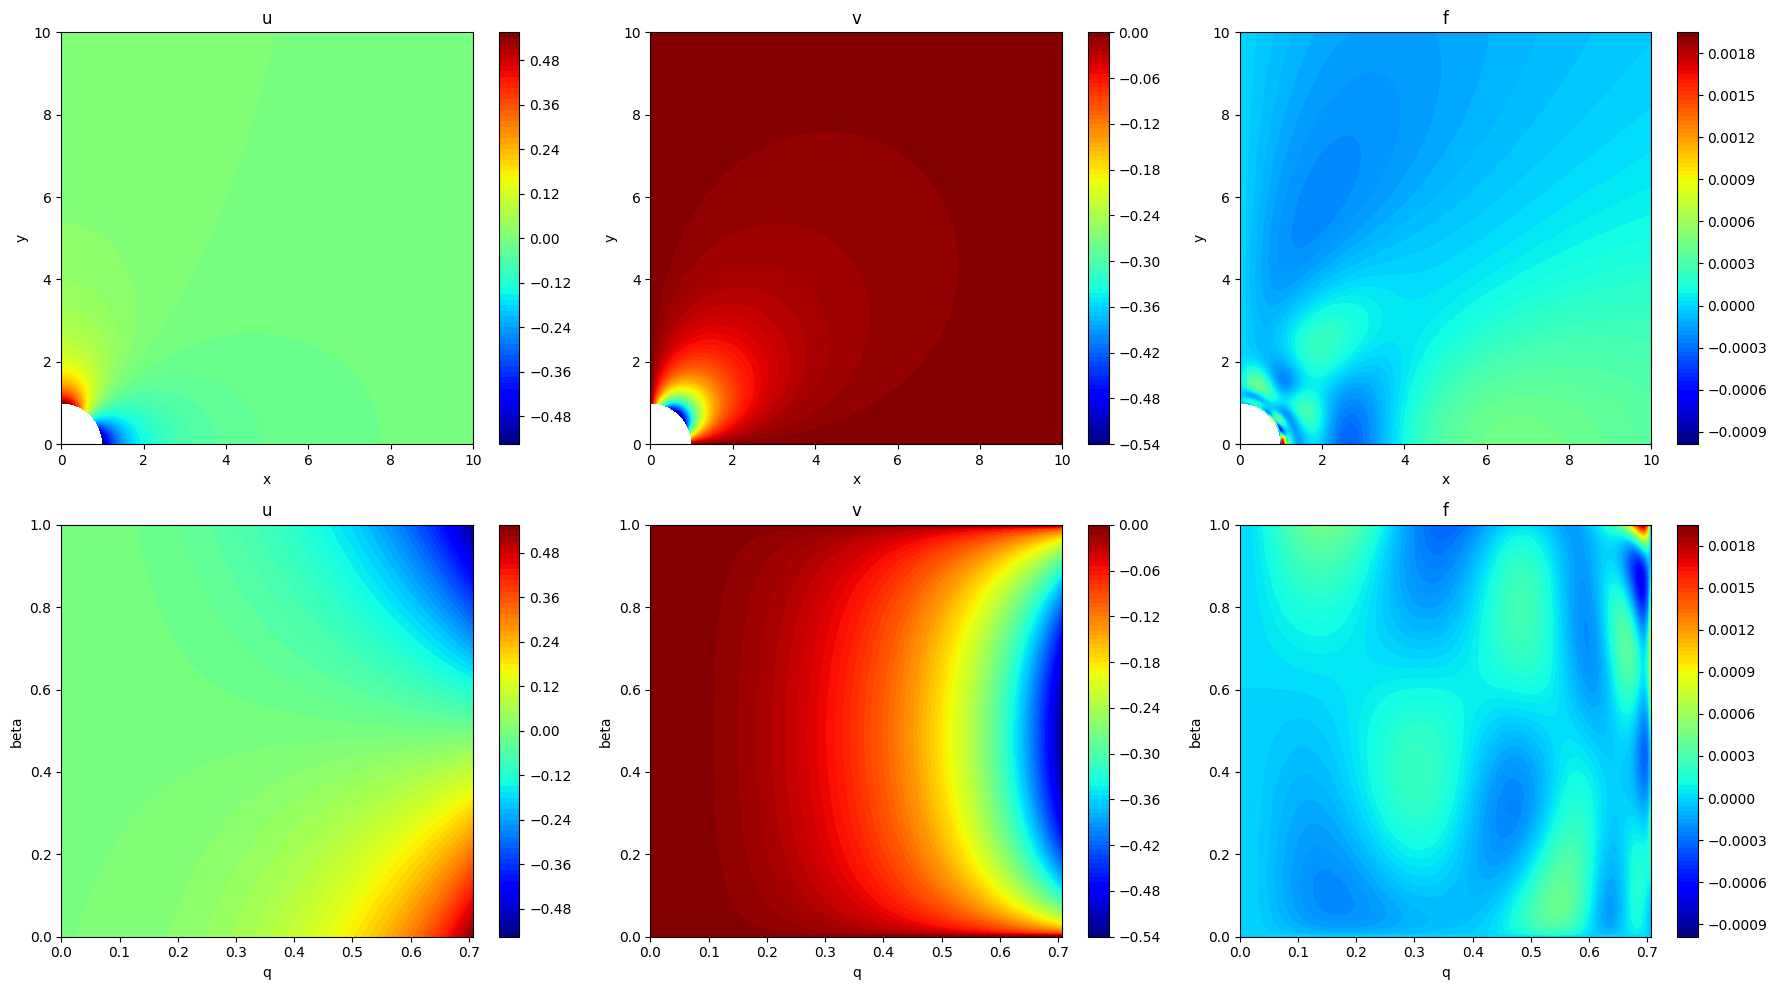

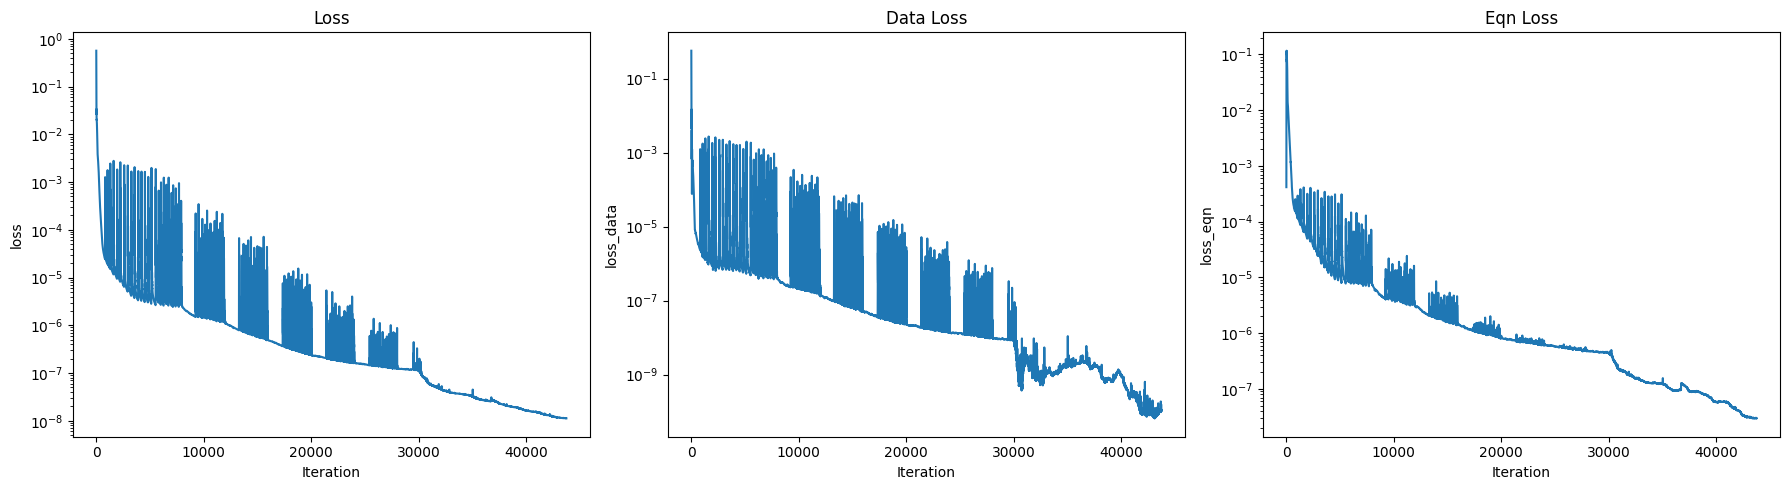

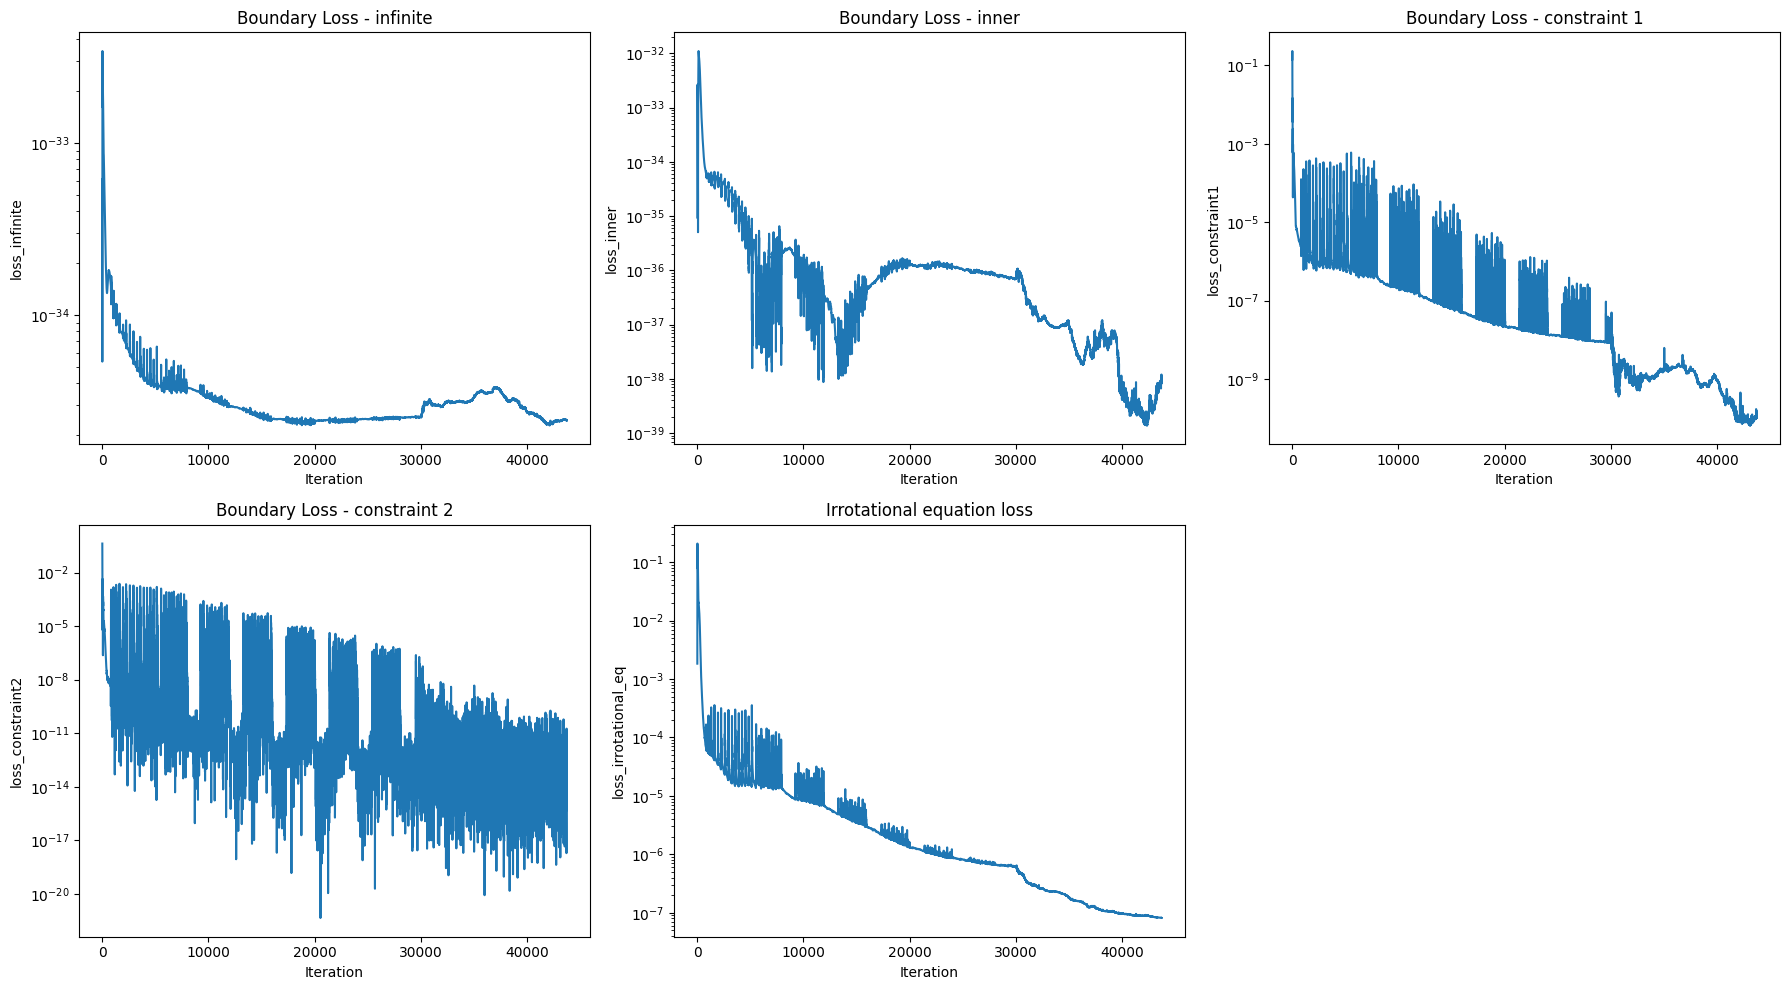

In [ ]:
"""Figure 1 - Result"""
fig1 = plt.figure(figsize=(18, 10))

ax1 = plt.subplot(231)
contour1 = ax1.contourf(X, Y, U1, 100, cmap='jet')
fig1.colorbar(contour1, ax=ax1)
ax1.set_title('u')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(0,10)
ax1.set_ylim(0,10)

ax2 = plt.subplot(232)
contour2 = ax2.contourf(X, Y, V1, 100, cmap='jet')
fig1.colorbar(contour2, ax=ax2)
ax2.set_title('v')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xlim(0,10)
ax2.set_ylim(0,10)

ax3 = plt.subplot(233)
contour3 = ax3.contourf(X, Y, F1, 100, cmap='jet')
fig1.colorbar(contour3, ax=ax3)
ax3.set_title('f')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_xlim(0,10)
ax3.set_ylim(0,10)

ax4 = plt.subplot(234)
contour4 = ax4.contourf(Q, BETA, U1, 100, cmap='jet')
fig1.colorbar(contour4, ax=ax4)
ax4.set_title('u')
ax4.set_xlabel('q')
ax4.set_ylabel('beta')

ax5 = plt.subplot(235)
contour5 = ax5.contourf(Q, BETA, V1, 100, cmap='jet')
fig1.colorbar(contour5, ax=ax5)
ax5.set_title('v')
ax5.set_xlabel('q')
ax5.set_ylabel('beta')

ax6 = plt.subplot(236)
contour6 = ax6.contourf(Q, BETA, F1, 100, cmap='jet')
fig1.colorbar(contour6, ax=ax6)
ax6.set_title('f')
ax6.set_xlabel('q')
ax6.set_ylabel('beta')

plt.tight_layout()
plt.show()

"""Figure 2 - Loss_d + Loss_e"""
fig2 = plt.figure(figsize=(18, 5))

# subplot - loss
ax1 = plt.subplot(131)
ax1.plot(range(len(loss_all1)), loss_all1[:, 0])
ax1.set_yscale('log')
ax1.set_title('Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('loss')

# subplot - loss_data
ax2 = plt.subplot(132)
ax2.plot(range(len(loss_all1)), loss_all1[:, 1])
ax2.set_yscale('log')
ax2.set_title('Data Loss')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('loss_data')

# subplot - loss_eqn
ax3 = plt.subplot(133)
ax3.plot(range(len(loss_all1)), loss_all1[:, -1])
ax3.set_yscale('log')
ax3.set_title('Eqn Loss')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('loss_eqn')

plt.tight_layout()
plt.show()

"""Figure 4 - Loss_d + Loss_e (specific)"""
fig3 = plt.figure(figsize=(18, 10))

# subplot - boundary loss - xy_inf
ax1 = plt.subplot(231)
ax1.plot(range(len(loss_all1)), loss_all1[:, 3])
ax1.set_yscale('log')
ax1.set_title('Boundary Loss - infinite')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('loss_infinite')

# subplot - boundary loss - xy_inner
ax2 = plt.subplot(232)
ax2.plot(range(len(loss_all1)), loss_all1[:, 4])
ax2.set_yscale('log')
ax2.set_title('Boundary Loss - inner')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('loss_inner')

# subplot - boundary loss - constraint 1
ax3 = plt.subplot(233)
ax3.plot(range(len(loss_all1)), loss_all1[:, 5])
ax3.set_yscale('log')
ax3.set_title('Boundary Loss - constraint 1')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('loss_constraint1')

# subplot - boundary loss - constraint 2
ax4 = plt.subplot(234)
ax4.plot(range(len(loss_all1)), loss_all1[:, 6])
ax4.set_yscale('log')
ax4.set_title('Boundary Loss - constraint 2')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('loss_constraint2')

# subplot - boundary loss - irrotational equation loss
ax4 = plt.subplot(235)
ax4.plot(range(len(loss_all1)), loss_all1[:, -2])
ax4.set_yscale('log')
ax4.set_title('Irrotational equation loss')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('loss_irrotational_eq')

plt.tight_layout()
plt.show()

In [ ]:
"""RMS for equation and solution error"""
r1_rms = ms_error(f_p1) ** 0.5
print('r1=', r1_rms)

r1= [0.00015289]


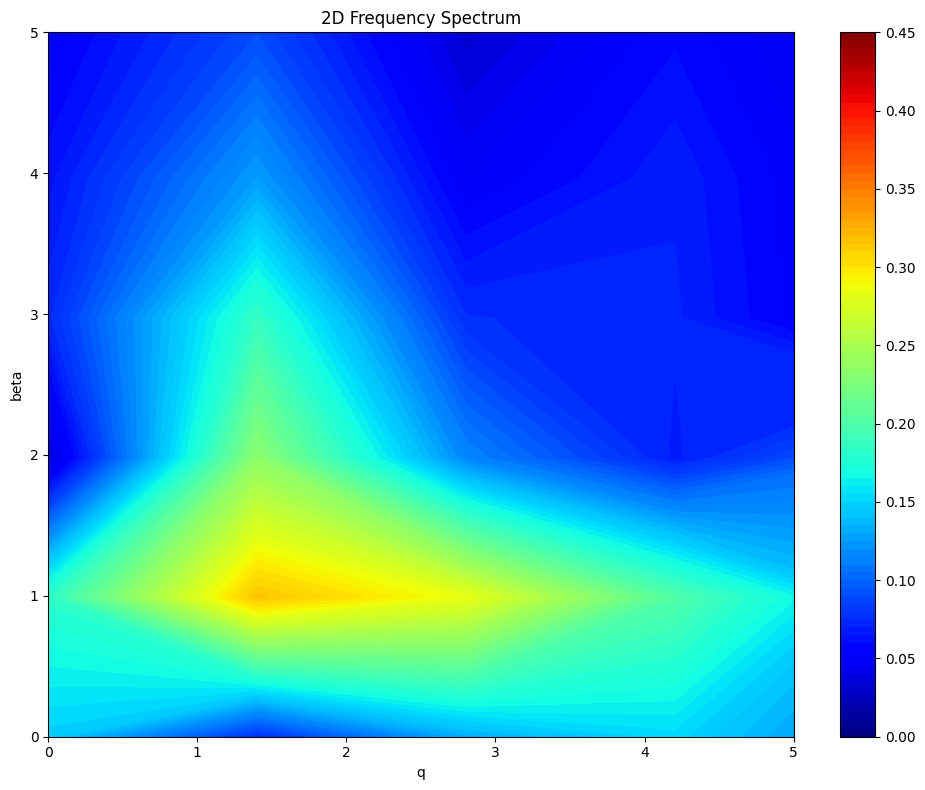

In [ ]:
from scipy.fftpack import fft2, fftshift, fftfreq

# Perform FFT on F1 in (q, beta) domain
F1_np = np.array(F1)
F1_fft = fftshift(fft2(F1_np))
magnitude = np.abs(F1_fft)

# Frequency axes
dq = q[1] - q[0]
db = beta[1] - beta[0]
freq_q = fftshift(fftfreq(len(q), d=dq))
freq_beta = fftshift(fftfreq(len(beta), d=db))

# Plot the frequency spectrum
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(freq_q, freq_beta, np.log1p(magnitude), 100, cmap='jet')
fig.colorbar(contour, ax=ax)
ax.set_title("2D Frequency Spectrum")
ax.set_xlabel("q")
ax.set_ylabel("beta")
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
plt.tight_layout()

# 2nd stage neural network

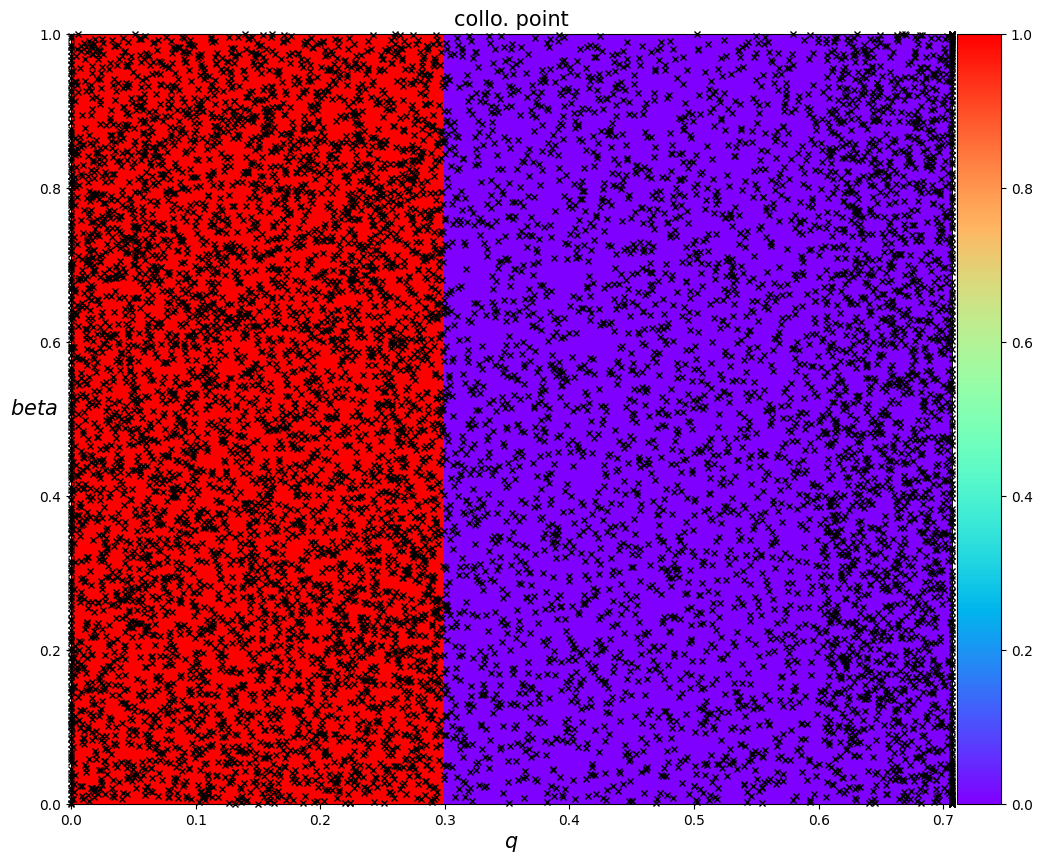

In [ ]:
# select the size of neural network
n_hl2 = 6
n_unit2 = 60
scl2 = 10
epsil2 = 1e-4/2

# number of sampling points (x_col, x_bd, x_add)
N_col2 = jnp.array([6000, 1000, 3000])
N_bd2 = N_bd * 2

# initialize the weights and biases of the network
trained_params2 = sol_init_MLP(keys[5], n_hl2, n_unit2)

# set the training iteration
lw2 = jnp.array([0.1/2, 1])

# create the solution function (act_s: tan-0, sin-1)
pred_u2 = mNN_pred_create(f_u1, limit, scl2, epsil2, act_s=1)

# create the data function
dataf2 = data_func_create(N_col2, N_bd2, mode_cbd=2)
Fs=data_sampling(Q,BETA,mode=1)
key_adam = keys[6]
key_lbfgs = random.split(keys[7], 1)
data2 = dataf2(key_adam, Fs, Q, BETA)

# plot the collocation point
plot = 1
if plot == 1:
    q_c2 = data2['q_col']
    colpoint_plot(Fs, q_c2, [0.0, 2 ** (-1 / 2), -0.0, 1.0], ['collo. point', '$q$', '$beta$'])

# calculate the loss function
NN_loss = loss_create(pred_u2, lw2, loss_ref=1)
NN_loss.ref = NN_loss(trained_params2, data2)[1][0]

Step: 100 | Loss: 4.5957e-09 | Loss_d: 5.7475e-11 | Loss_e: 1.8066e-08 | 
Step: 200 | Loss: 3.4855e-09 | Loss_d: 3.1551e-11 | Loss_e: 1.5080e-08 | 
Step: 300 | Loss: 3.3318e-09 | Loss_d: 1.2099e-10 | Loss_e: 1.7148e-08 | 
Step: 400 | Loss: 2.8461e-09 | Loss_d: 1.4485e-11 | Loss_e: 1.5244e-08 | 
Step: 500 | Loss: 2.6234e-09 | Loss_d: 1.4703e-11 | Loss_e: 1.4619e-08 | 
Step: 600 | Loss: 2.4714e-09 | Loss_d: 8.3629e-11 | Loss_e: 1.3607e-08 | 
Step: 700 | Loss: 2.1840e-09 | Loss_d: 7.7697e-12 | Loss_e: 1.3111e-08 | 
Step: 800 | Loss: 2.0805e-09 | Loss_d: 7.2851e-12 | Loss_e: 1.2989e-08 | 
Step: 900 | Loss: 2.8883e-09 | Loss_d: 9.0980e-10 | Loss_e: 1.3188e-08 | 
Step: 1000 | Loss: 1.7169e-09 | Loss_d: 5.3019e-12 | Loss_e: 1.0605e-08 | 
Step: 1100 | Loss: 1.7103e-09 | Loss_d: 6.0192e-12 | Loss_e: 1.1159e-08 | 
Step: 1200 | Loss: 6.7942e-09 | Loss_d: 5.1190e-09 | Loss_e: 1.1787e-08 | 
Step: 1300 | Loss: 1.5200e-09 | Loss_d: 5.0594e-12 | Loss_e: 1.0053e-08 | 
Step: 1400 | Loss: 1.4335e-09 | Lo

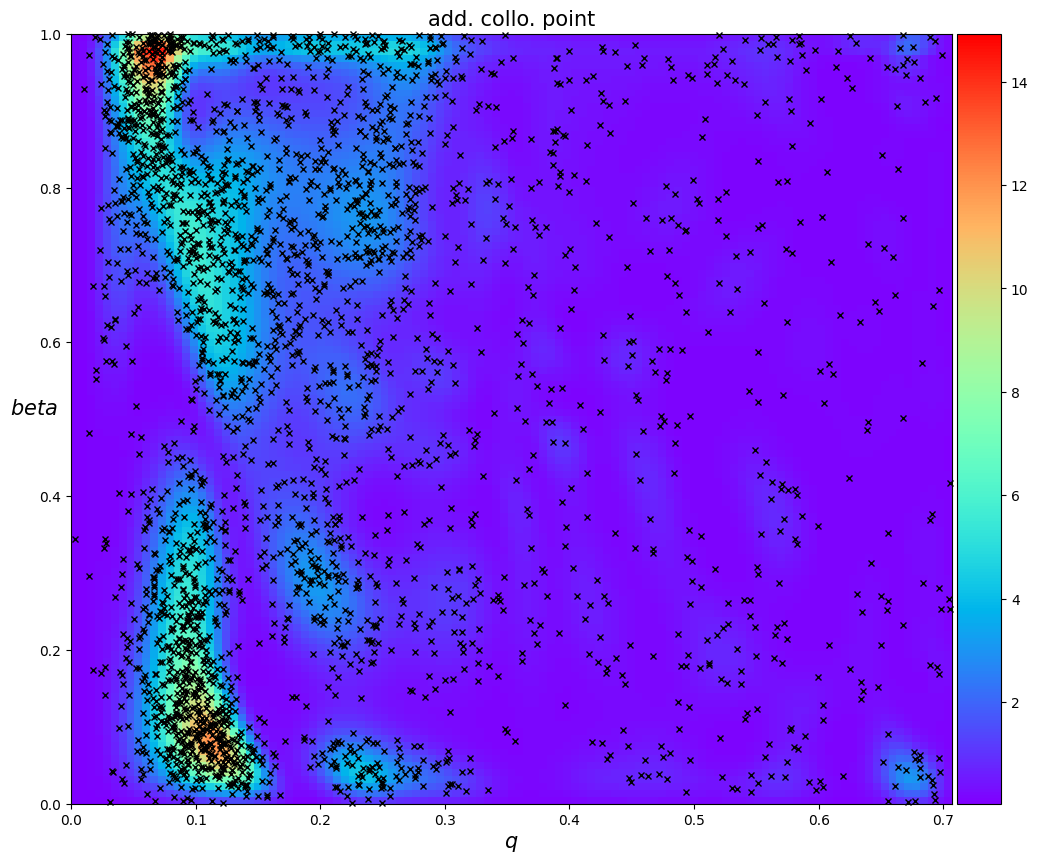

Step: 4100 | Loss: 7.5982e-10 | Loss_d: 1.4114e-12 | Loss_e: 3.9527e-09 | 
Step: 4200 | Loss: 7.1953e-10 | Loss_d: 3.1081e-12 | Loss_e: 3.9384e-09 | 
Step: 4300 | Loss: 7.1900e-10 | Loss_d: 1.4627e-12 | Loss_e: 3.9793e-09 | 
Step: 4400 | Loss: 6.9670e-10 | Loss_d: 1.2179e-12 | Loss_e: 3.8958e-09 | 
Step: 4500 | Loss: 6.7692e-10 | Loss_d: 1.6684e-12 | Loss_e: 3.7651e-09 | 
Step: 4600 | Loss: 6.6618e-10 | Loss_d: 5.7779e-12 | Loss_e: 3.8470e-09 | 
Step: 4700 | Loss: 6.6314e-10 | Loss_d: 1.1289e-12 | Loss_e: 3.7514e-09 | 
Step: 4800 | Loss: 6.2889e-10 | Loss_d: 9.3315e-13 | Loss_e: 3.5401e-09 | 
Step: 4900 | Loss: 6.1053e-10 | Loss_d: 3.7937e-12 | Loss_e: 3.5179e-09 | 
Step: 5000 | Loss: 6.1609e-10 | Loss_d: 7.6009e-13 | Loss_e: 3.5592e-09 | 
Step: 5100 | Loss: 6.2314e-10 | Loss_d: 2.3904e-11 | Loss_e: 3.5989e-09 | 
Step: 5200 | Loss: 5.8847e-10 | Loss_d: 9.9845e-13 | Loss_e: 3.5010e-09 | 
Step: 5300 | Loss: 5.6908e-10 | Loss_d: 1.0010e-12 | Loss_e: 3.3705e-09 | 
Step: 5400 | Loss: 5.6106

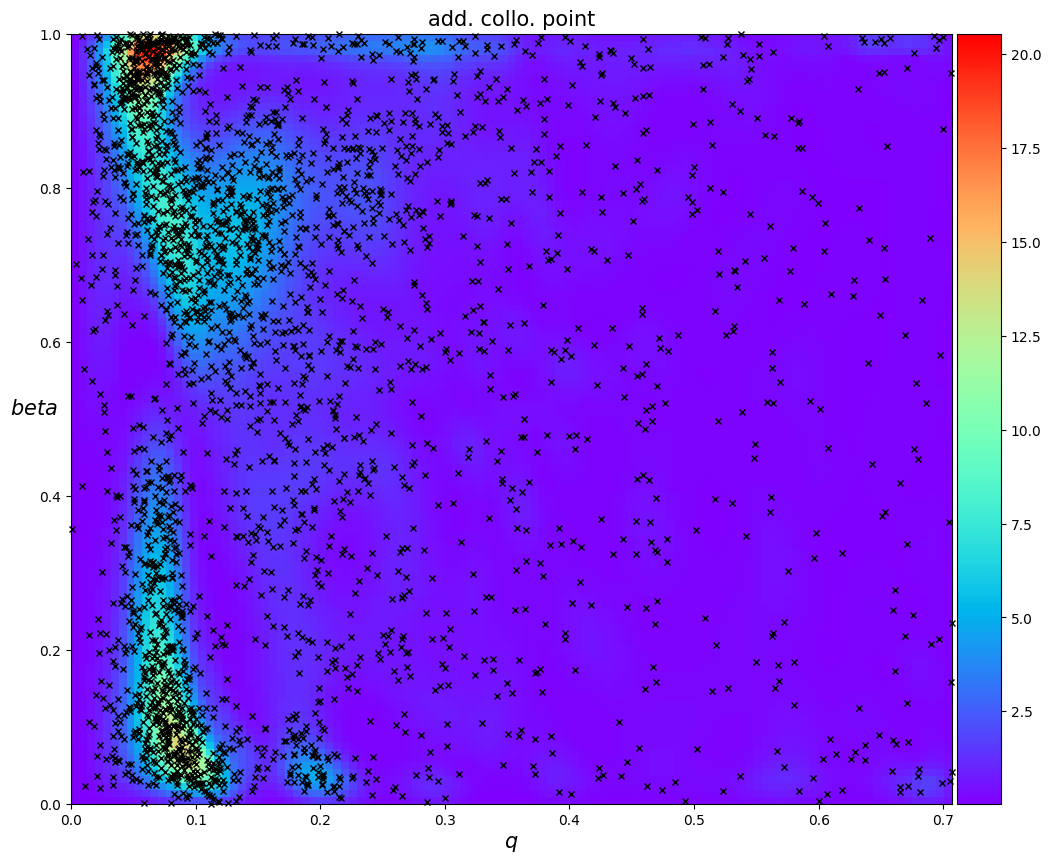

Step: 8100 | Loss: 3.6409e-10 | Loss_d: 4.1662e-13 | Loss_e: 2.3106e-09 | 
Step: 8200 | Loss: 3.5543e-10 | Loss_d: 3.5908e-13 | Loss_e: 2.2593e-09 | 
Step: 8300 | Loss: 3.3955e-10 | Loss_d: 4.1787e-13 | Loss_e: 2.2362e-09 | 
Step: 8400 | Loss: 3.2508e-10 | Loss_d: 4.6574e-13 | Loss_e: 2.0246e-09 | 
Step: 8500 | Loss: 3.2808e-10 | Loss_d: 3.0726e-13 | Loss_e: 2.1202e-09 | 
Step: 8600 | Loss: 3.2828e-10 | Loss_d: 1.2339e-12 | Loss_e: 2.0998e-09 | 
Step: 8700 | Loss: 3.1592e-10 | Loss_d: 3.1407e-13 | Loss_e: 2.0424e-09 | 
Step: 8800 | Loss: 3.1045e-10 | Loss_d: 4.6763e-13 | Loss_e: 2.0732e-09 | 
Step: 8900 | Loss: 3.1137e-10 | Loss_d: 3.9211e-13 | Loss_e: 2.0031e-09 | 
Step: 9000 | Loss: 2.9273e-10 | Loss_d: 2.6082e-13 | Loss_e: 1.9683e-09 | 
Step: 9100 | Loss: 3.0672e-10 | Loss_d: 9.3603e-13 | Loss_e: 2.0492e-09 | 
Step: 9200 | Loss: 2.8560e-10 | Loss_d: 2.1761e-13 | Loss_e: 1.9368e-09 | 
Step: 9300 | Loss: 2.9533e-10 | Loss_d: 7.0889e-13 | Loss_e: 1.9203e-09 | 
Step: 9400 | Loss: 2.9202

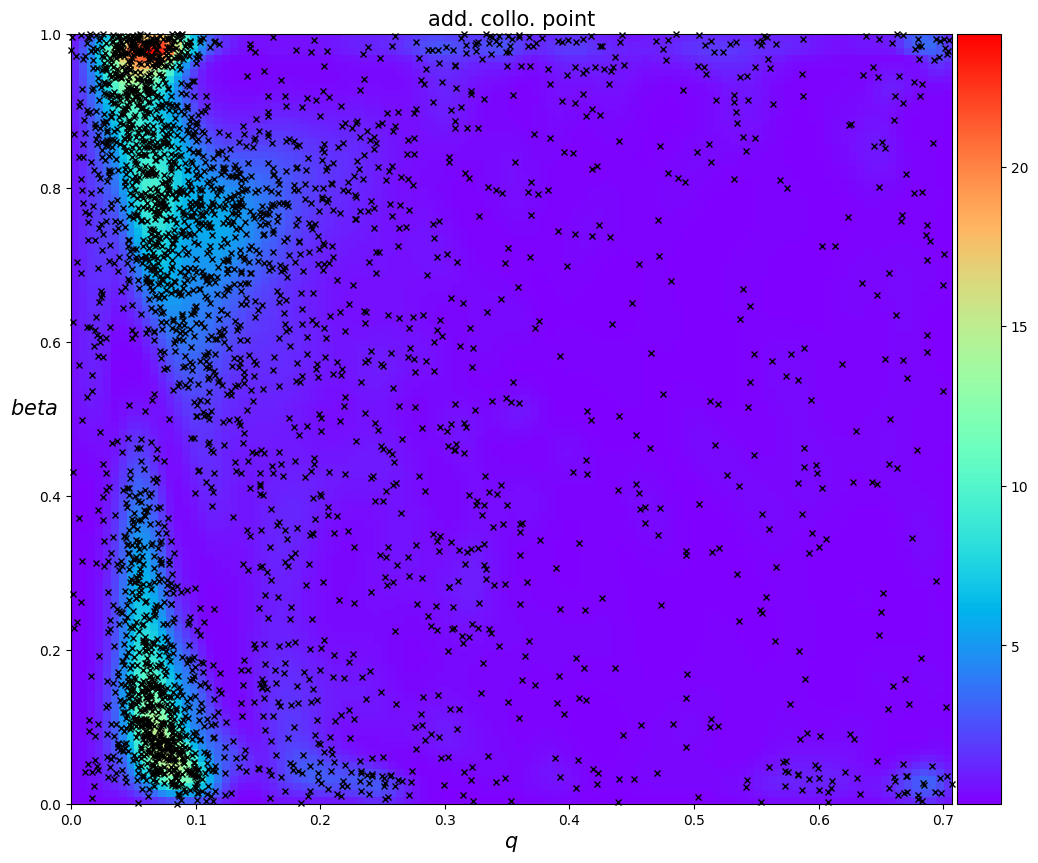

Step: 12100 | Loss: 1.9483e-10 | Loss_d: 2.6568e-12 | Loss_e: 1.3458e-09 | 
Step: 12200 | Loss: 1.8674e-10 | Loss_d: 1.7667e-12 | Loss_e: 1.3432e-09 | 
Step: 12300 | Loss: 1.8278e-10 | Loss_d: 1.8710e-13 | Loss_e: 1.3155e-09 | 
Step: 12400 | Loss: 1.8121e-10 | Loss_d: 3.5402e-13 | Loss_e: 1.2665e-09 | 
Step: 12500 | Loss: 1.8007e-10 | Loss_d: 1.7633e-13 | Loss_e: 1.2468e-09 | 
Step: 12600 | Loss: 1.7320e-10 | Loss_d: 1.9987e-13 | Loss_e: 1.2314e-09 | 
Step: 12700 | Loss: 1.6788e-10 | Loss_d: 2.1347e-13 | Loss_e: 1.2423e-09 | 
Step: 12800 | Loss: 1.6412e-10 | Loss_d: 6.2364e-13 | Loss_e: 1.1902e-09 | 
Step: 12900 | Loss: 1.7046e-10 | Loss_d: 3.2035e-12 | Loss_e: 1.2125e-09 | 
Step: 13000 | Loss: 3.3422e-10 | Loss_d: 1.2238e-10 | Loss_e: 1.3175e-09 | 
Step: 13100 | Loss: 1.6049e-10 | Loss_d: 6.9473e-13 | Loss_e: 1.1413e-09 | 
Step: 13200 | Loss: 1.5686e-10 | Loss_d: 1.2551e-13 | Loss_e: 1.1050e-09 | 
Step: 13300 | Loss: 1.5552e-10 | Loss_d: 1.0854e-12 | Loss_e: 1.0664e-09 | 
Step: 13400 

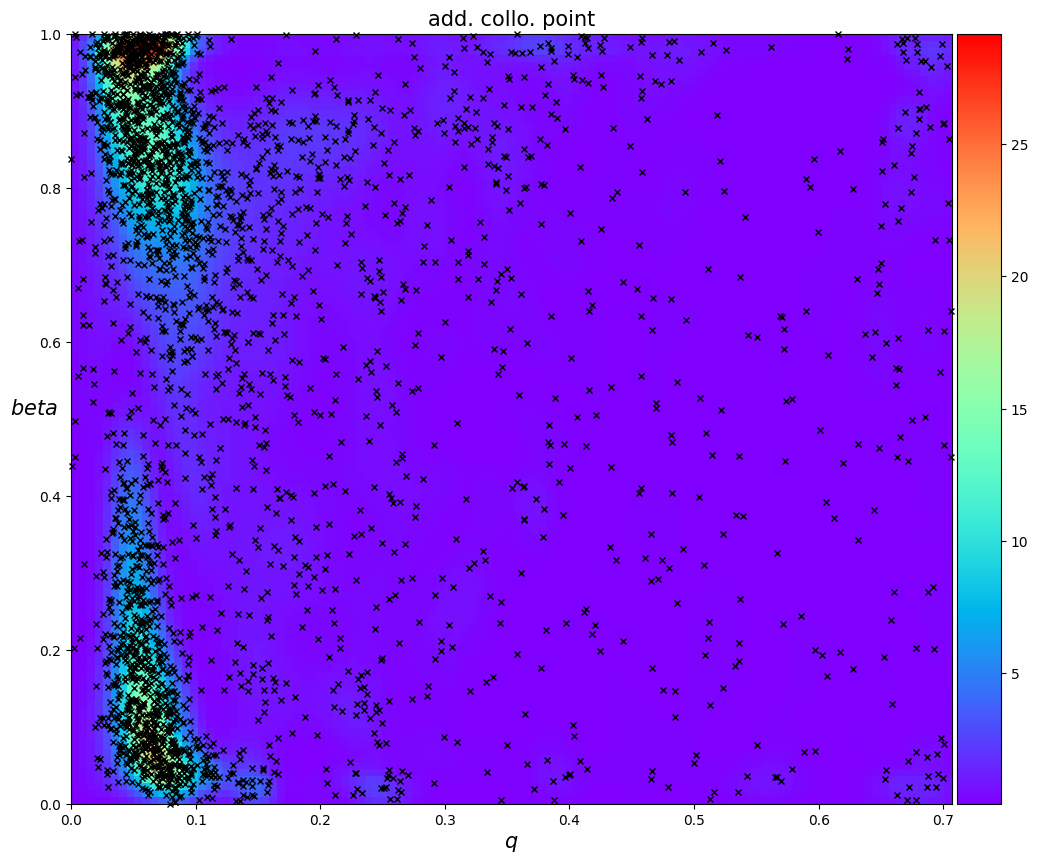

Step: 16100 | Loss: 1.1420e-10 | Loss_d: 4.2686e-12 | Loss_e: 7.9121e-10 | 
Step: 16200 | Loss: 1.0177e-10 | Loss_d: 3.5384e-13 | Loss_e: 7.4189e-10 | 
Step: 16300 | Loss: 1.2952e-10 | Loss_d: 1.3128e-11 | Loss_e: 8.1984e-10 | 
Step: 16400 | Loss: 1.0192e-10 | Loss_d: 1.8696e-12 | Loss_e: 7.2994e-10 | 
Step: 16500 | Loss: 1.1885e-10 | Loss_d: 1.1700e-11 | Loss_e: 8.2653e-10 | 
Step: 16600 | Loss: 9.2401e-11 | Loss_d: 2.1650e-13 | Loss_e: 6.7273e-10 | 
Step: 16700 | Loss: 9.5984e-11 | Loss_d: 4.6646e-13 | Loss_e: 7.2100e-10 | 
Step: 16800 | Loss: 9.1815e-11 | Loss_d: 3.3150e-13 | Loss_e: 6.8867e-10 | 
Step: 16900 | Loss: 9.0308e-11 | Loss_d: 9.5311e-14 | Loss_e: 6.4004e-10 | 
Step: 17000 | Loss: 8.6849e-11 | Loss_d: 7.9453e-14 | Loss_e: 6.4570e-10 | 
Step: 17100 | Loss: 1.1909e-10 | Loss_d: 2.6222e-11 | Loss_e: 7.1239e-10 | 
Step: 17200 | Loss: 8.3977e-11 | Loss_d: 1.2236e-13 | Loss_e: 6.1430e-10 | 
Step: 17300 | Loss: 8.4493e-11 | Loss_d: 6.0352e-14 | Loss_e: 6.1970e-10 | 
Step: 17400 

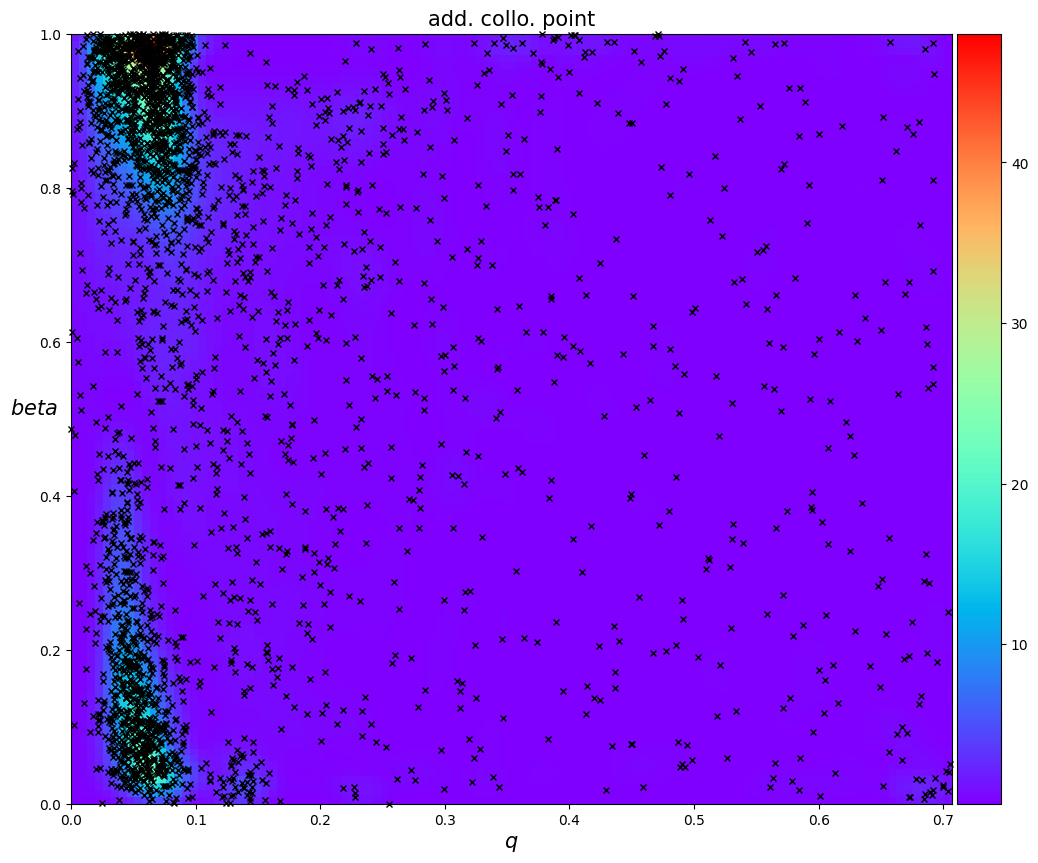

Step: 20100 | Loss: 7.3694e-11 | Loss_d: 5.7280e-12 | Loss_e: 5.5519e-10 | 
Step: 20200 | Loss: 5.2951e-11 | Loss_d: 4.8850e-13 | Loss_e: 3.8277e-10 | 
Step: 20300 | Loss: 5.6330e-11 | Loss_d: 4.5889e-13 | Loss_e: 3.9925e-10 | 
Step: 20400 | Loss: 5.1115e-11 | Loss_d: 8.2762e-13 | Loss_e: 3.6643e-10 | 
Step: 20500 | Loss: 5.2738e-11 | Loss_d: 2.3256e-13 | Loss_e: 3.8387e-10 | 
Step: 20600 | Loss: 5.5059e-11 | Loss_d: 1.0245e-12 | Loss_e: 3.9699e-10 | 
Step: 20700 | Loss: 5.3682e-11 | Loss_d: 2.2095e-12 | Loss_e: 3.8131e-10 | 
Step: 20800 | Loss: 5.1541e-11 | Loss_d: 6.2561e-13 | Loss_e: 3.6315e-10 | 
Step: 20900 | Loss: 5.2487e-11 | Loss_d: 1.4445e-12 | Loss_e: 3.8608e-10 | 
Step: 21000 | Loss: 4.6718e-11 | Loss_d: 1.1153e-13 | Loss_e: 3.3760e-10 | 
Step: 21100 | Loss: 4.5049e-11 | Loss_d: 3.5981e-13 | Loss_e: 3.2787e-10 | 
Step: 21200 | Loss: 4.7456e-11 | Loss_d: 6.3190e-13 | Loss_e: 3.4539e-10 | 
Step: 21300 | Loss: 4.2467e-11 | Loss_d: 1.6633e-13 | Loss_e: 3.2098e-10 | 
Step: 21400 

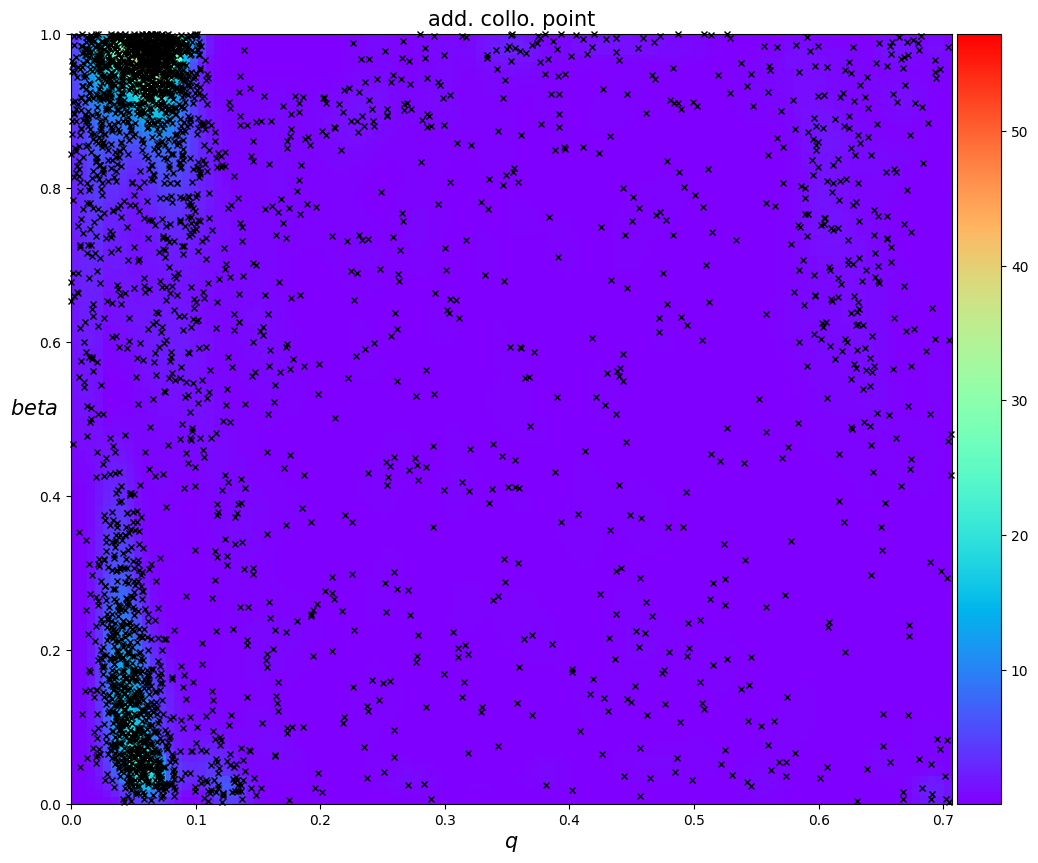

Step: 24100 | Loss: 3.2454e-11 | Loss_d: 2.3475e-13 | Loss_e: 2.4209e-10 | 
Step: 24200 | Loss: 2.9274e-11 | Loss_d: 1.0625e-13 | Loss_e: 2.0184e-10 | 
Step: 24300 | Loss: 3.3804e-11 | Loss_d: 2.3314e-12 | Loss_e: 2.3452e-10 | 
Step: 24400 | Loss: 3.6058e-11 | Loss_d: 1.2221e-12 | Loss_e: 2.6584e-10 | 
Step: 24500 | Loss: 2.9576e-11 | Loss_d: 1.1831e-13 | Loss_e: 2.1936e-10 | 
Step: 24600 | Loss: 2.8189e-11 | Loss_d: 6.1749e-14 | Loss_e: 2.0191e-10 | 
Step: 24700 | Loss: 3.0242e-11 | Loss_d: 5.5241e-13 | Loss_e: 2.2587e-10 | 
Step: 24800 | Loss: 2.8536e-11 | Loss_d: 5.6819e-13 | Loss_e: 2.0968e-10 | 
Step: 24900 | Loss: 2.6269e-11 | Loss_d: 1.4766e-13 | Loss_e: 2.0096e-10 | 
Step: 25000 | Loss: 3.7280e-11 | Loss_d: 8.4314e-12 | Loss_e: 2.0745e-10 | 
Step: 25100 | Loss: 2.7733e-11 | Loss_d: 4.4098e-13 | Loss_e: 2.1076e-10 | 
Step: 25200 | Loss: 2.5136e-11 | Loss_d: 4.2749e-13 | Loss_e: 1.8215e-10 | 
Step: 25300 | Loss: 2.9558e-11 | Loss_d: 1.3114e-12 | Loss_e: 2.1883e-10 | 
Step: 25400 

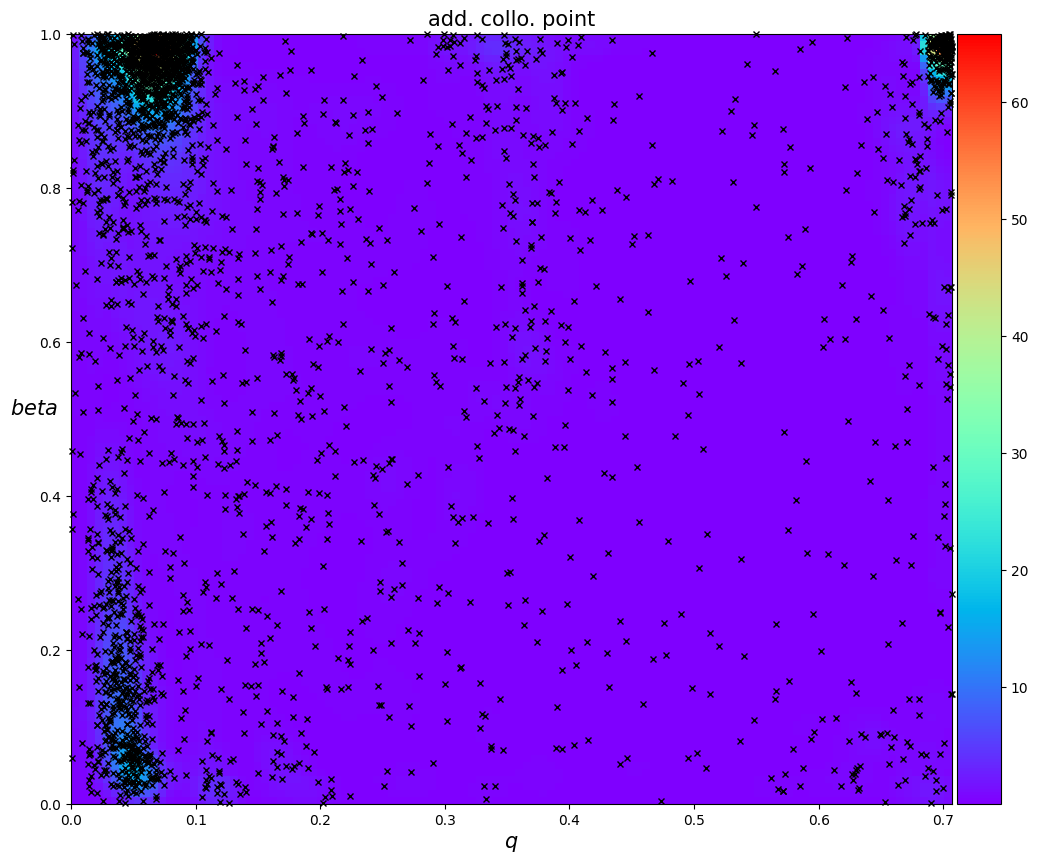

Step: 28100 | Loss: 1.9125e-09 | Loss_d: 1.7569e-11 | Loss_e: 1.5747e-08 | 
Step: 28200 | Loss: 1.1730e-09 | Loss_d: 1.0787e-11 | Loss_e: 9.8476e-09 | 
Step: 28300 | Loss: 8.3247e-10 | Loss_d: 1.2124e-11 | Loss_e: 6.9480e-09 | 
Step: 28400 | Loss: 6.9194e-10 | Loss_d: 3.5620e-11 | Loss_e: 4.8619e-09 | 
Step: 28500 | Loss: 5.3788e-10 | Loss_d: 4.3184e-12 | Loss_e: 3.8597e-09 | 
Step: 28600 | Loss: 4.8894e-10 | Loss_d: 9.8605e-12 | Loss_e: 3.1679e-09 | 
Step: 28700 | Loss: 4.4494e-10 | Loss_d: 2.6750e-11 | Loss_e: 2.7681e-09 | 
Step: 28800 | Loss: 3.8633e-10 | Loss_d: 5.9055e-12 | Loss_e: 2.5122e-09 | 
Step: 28900 | Loss: 3.3892e-10 | Loss_d: 4.0159e-12 | Loss_e: 2.2067e-09 | 
Step: 29000 | Loss: 3.5807e-10 | Loss_d: 4.4618e-11 | Loss_e: 2.0453e-09 | 
Step: 29100 | Loss: 2.6496e-10 | Loss_d: 1.7984e-12 | Loss_e: 1.6423e-09 | 
Step: 29200 | Loss: 2.3212e-10 | Loss_d: 1.4557e-12 | Loss_e: 1.5141e-09 | 
Step: 29300 | Loss: 2.2379e-10 | Loss_d: 1.9092e-12 | Loss_e: 1.4648e-09 | 
Step: 29400 

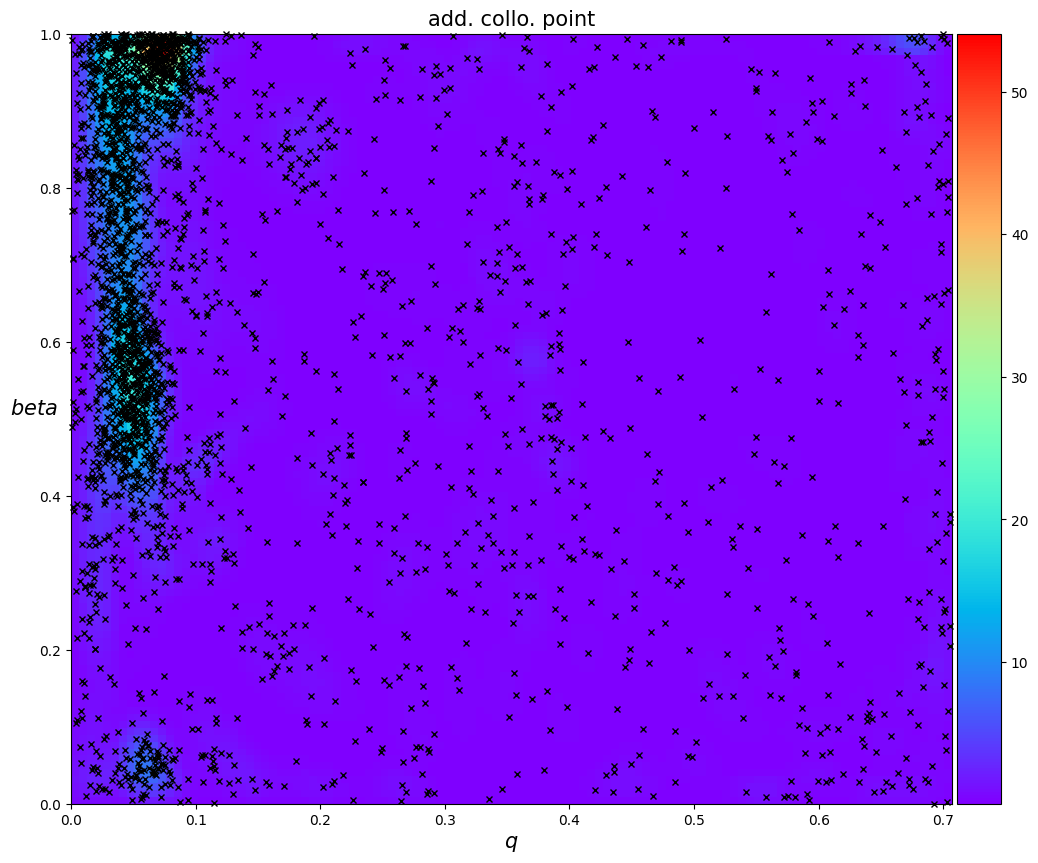

Step: 32100 | Loss: 4.0035e-11 | Loss_d: 4.1973e-13 | Loss_e: 3.8755e-10 | 
Step: 32200 | Loss: 3.3019e-11 | Loss_d: 1.0787e-13 | Loss_e: 3.1430e-10 | 
Step: 32300 | Loss: 3.0553e-11 | Loss_d: 9.1220e-14 | Loss_e: 2.8102e-10 | 
Step: 32400 | Loss: 2.7833e-11 | Loss_d: 1.2622e-13 | Loss_e: 2.5475e-10 | 
Step: 32500 | Loss: 2.6516e-11 | Loss_d: 8.5811e-14 | Loss_e: 2.3661e-10 | 
Step: 32600 | Loss: 2.4952e-11 | Loss_d: 1.1214e-13 | Loss_e: 2.2157e-10 | 
Step: 32700 | Loss: 2.5189e-11 | Loss_d: 2.9551e-13 | Loss_e: 2.1766e-10 | 
Step: 32800 | Loss: 3.5605e-11 | Loss_d: 9.5421e-12 | Loss_e: 2.2018e-10 | 
Step: 32900 | Loss: 3.4370e-11 | Loss_d: 1.1743e-11 | Loss_e: 1.8373e-10 | 
Step: 33000 | Loss: 2.3373e-11 | Loss_d: 1.9425e-12 | Loss_e: 1.7959e-10 | 
Step: 33100 | Loss: 2.1589e-11 | Loss_d: 7.0668e-13 | Loss_e: 1.6681e-10 | 
Step: 33200 | Loss: 1.9234e-11 | Loss_d: 1.9294e-13 | Loss_e: 1.5562e-10 | 
Step: 33300 | Loss: 1.7665e-11 | Loss_d: 3.8945e-13 | Loss_e: 1.4355e-10 | 
Step: 33400 

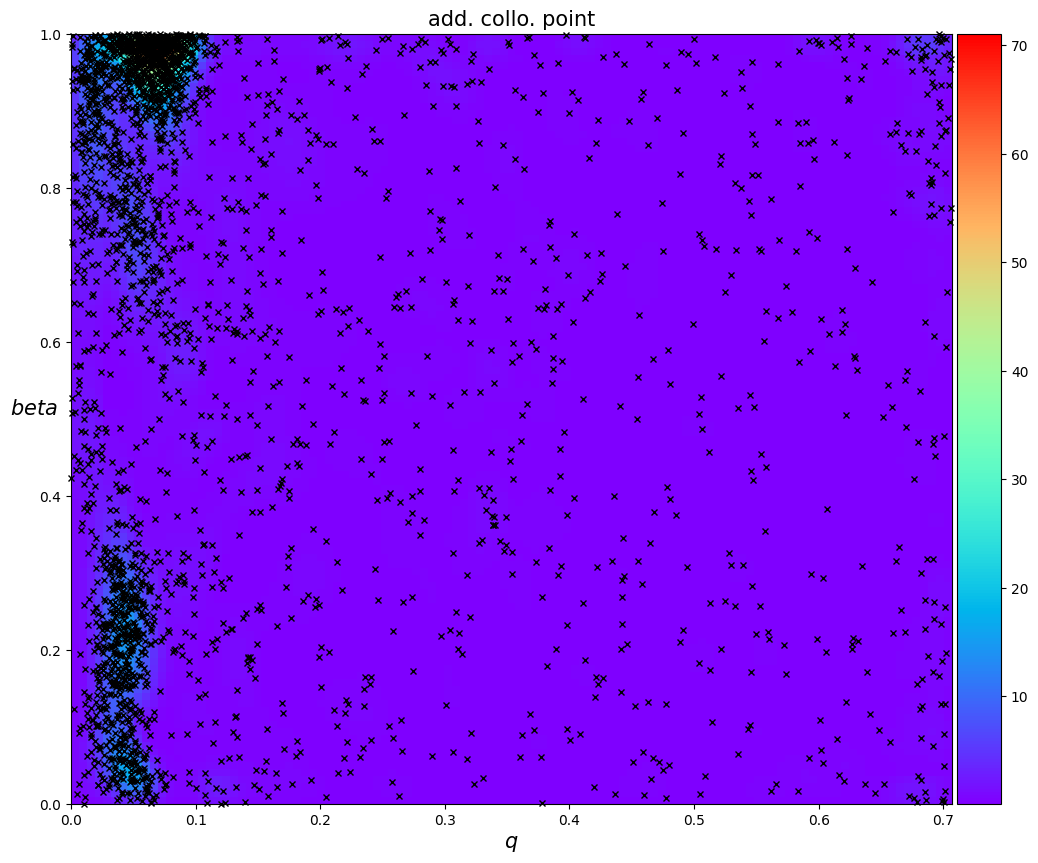

Step: 36100 | Loss: 1.6358e-11 | Loss_d: 5.1627e-13 | Loss_e: 1.2858e-10 | 
Step: 36200 | Loss: 1.2619e-11 | Loss_d: 1.2363e-13 | Loss_e: 9.9913e-11 | 
Step: 36300 | Loss: 1.6258e-11 | Loss_d: 1.7300e-12 | Loss_e: 1.1214e-10 | 
Step: 36400 | Loss: 1.1685e-11 | Loss_d: 9.0036e-14 | Loss_e: 8.6160e-11 | 
Step: 36500 | Loss: 1.1710e-11 | Loss_d: 1.3689e-13 | Loss_e: 8.8640e-11 | 
Step: 36600 | Loss: 1.1725e-11 | Loss_d: 1.7331e-13 | Loss_e: 8.6092e-11 | 
Step: 36700 | Loss: 1.1924e-11 | Loss_d: 4.3764e-13 | Loss_e: 8.4681e-11 | 
Step: 36800 | Loss: 1.4265e-11 | Loss_d: 1.2692e-12 | Loss_e: 9.8572e-11 | 
Step: 36900 | Loss: 1.1931e-11 | Loss_d: 4.8621e-13 | Loss_e: 8.6357e-11 | 
Step: 37000 | Loss: 1.1660e-11 | Loss_d: 3.5611e-13 | Loss_e: 8.5342e-11 | 
Step: 37100 | Loss: 1.1224e-11 | Loss_d: 2.4398e-13 | Loss_e: 8.0974e-11 | 
Step: 37200 | Loss: 1.3409e-11 | Loss_d: 3.8181e-13 | Loss_e: 9.8825e-11 | 
Step: 37300 | Loss: 1.1584e-11 | Loss_d: 5.1896e-13 | Loss_e: 8.5186e-11 | 
Step: 37400 

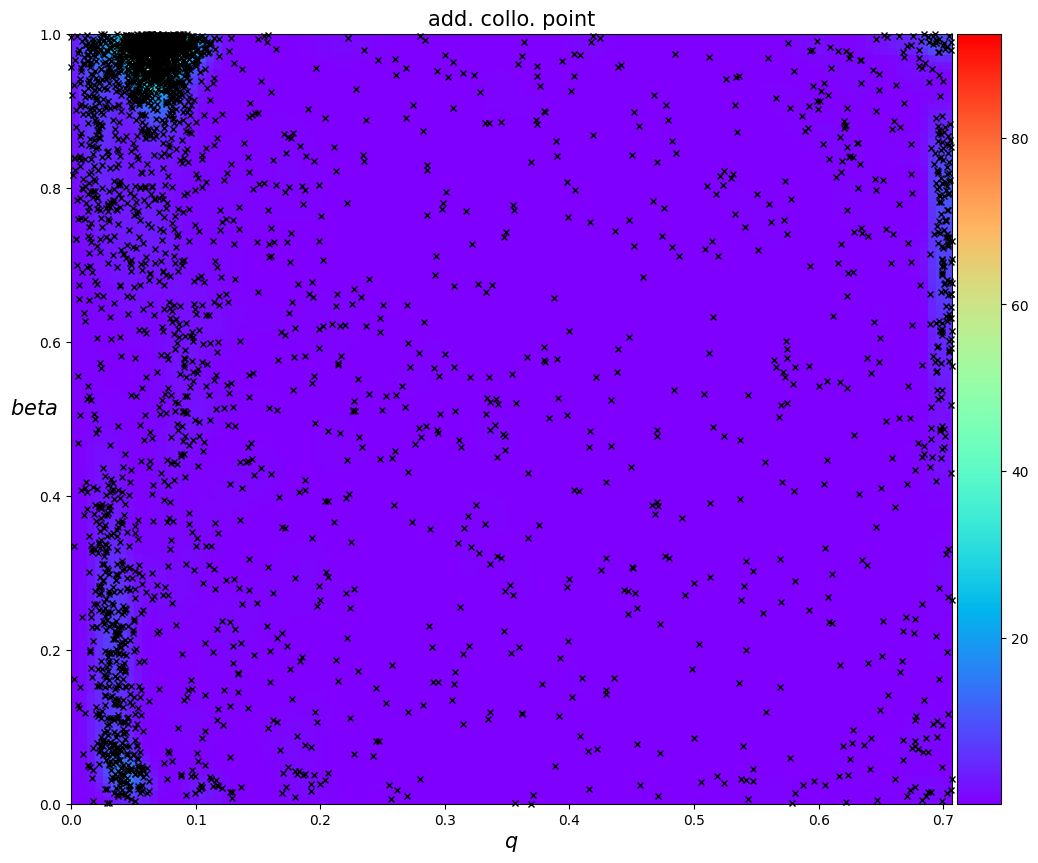

Step: 40100 | Loss: 7.7933e-12 | Loss_d: 4.5571e-14 | Loss_e: 5.9081e-11 | 
Step: 40200 | Loss: 7.5433e-12 | Loss_d: 1.7060e-13 | Loss_e: 5.5163e-11 | 
Step: 40300 | Loss: 7.5379e-12 | Loss_d: 9.5482e-14 | Loss_e: 5.6905e-11 | 
Step: 40400 | Loss: 7.6239e-12 | Loss_d: 4.9424e-14 | Loss_e: 5.4652e-11 | 
Step: 40500 | Loss: 7.2875e-12 | Loss_d: 4.4947e-14 | Loss_e: 5.3145e-11 | 
Step: 40600 | Loss: 7.1454e-12 | Loss_d: 3.2490e-14 | Loss_e: 5.3066e-11 | 
Step: 40700 | Loss: 7.2490e-12 | Loss_d: 6.5819e-14 | Loss_e: 5.3601e-11 | 
Step: 40800 | Loss: 7.3770e-12 | Loss_d: 4.0712e-14 | Loss_e: 5.4042e-11 | 
Step: 40900 | Loss: 7.1755e-12 | Loss_d: 2.9042e-14 | Loss_e: 5.4940e-11 | 
Step: 41000 | Loss: 7.4759e-12 | Loss_d: 3.7790e-14 | Loss_e: 5.7289e-11 | 
Step: 41100 | Loss: 7.4594e-12 | Loss_d: 4.7823e-13 | Loss_e: 5.1205e-11 | 
Step: 41200 | Loss: 6.9615e-12 | Loss_d: 6.0943e-14 | Loss_e: 5.3905e-11 | 
Step: 41300 | Loss: 8.4222e-12 | Loss_d: 5.3940e-13 | Loss_e: 6.2570e-11 | 
Step: 41400 

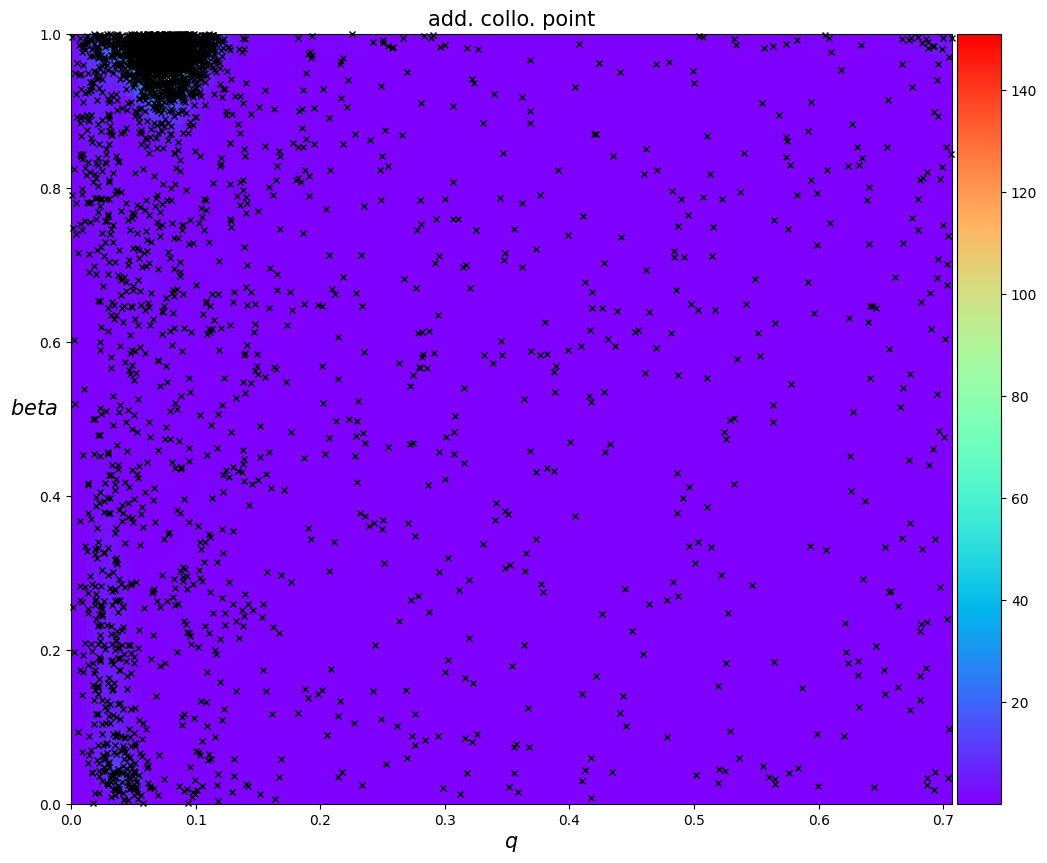

Step: 44100 | Loss: 5.3353e-12 | Loss_d: 2.6074e-14 | Loss_e: 4.0999e-11 | 
Step: 44200 | Loss: 5.3263e-12 | Loss_d: 2.3267e-14 | Loss_e: 4.0333e-11 | 
Step: 44300 | Loss: 5.2189e-12 | Loss_d: 2.4477e-14 | Loss_e: 3.8317e-11 | 
Step: 44400 | Loss: 4.9563e-12 | Loss_d: 2.1748e-14 | Loss_e: 3.8970e-11 | 
Step: 44500 | Loss: 5.0969e-12 | Loss_d: 1.8879e-14 | Loss_e: 3.7046e-11 | 
Step: 44600 | Loss: 4.9382e-12 | Loss_d: 5.3141e-14 | Loss_e: 3.5752e-11 | 
Step: 44700 | Loss: 5.0471e-12 | Loss_d: 1.8498e-14 | Loss_e: 3.6222e-11 | 
Step: 44800 | Loss: 4.6855e-12 | Loss_d: 1.5779e-14 | Loss_e: 3.2821e-11 | 
Step: 44900 | Loss: 4.9133e-12 | Loss_d: 1.6693e-14 | Loss_e: 3.7123e-11 | 
Step: 45000 | Loss: 4.8398e-12 | Loss_d: 1.9886e-14 | Loss_e: 3.4466e-11 | 
Step: 45100 | Loss: 4.8329e-12 | Loss_d: 2.2876e-14 | Loss_e: 3.3593e-11 | 
Step: 45200 | Loss: 4.8046e-12 | Loss_d: 1.8822e-14 | Loss_e: 3.5548e-11 | 
Step: 45300 | Loss: 4.9340e-12 | Loss_d: 2.3879e-14 | Loss_e: 3.5186e-11 | 
Step: 45400 

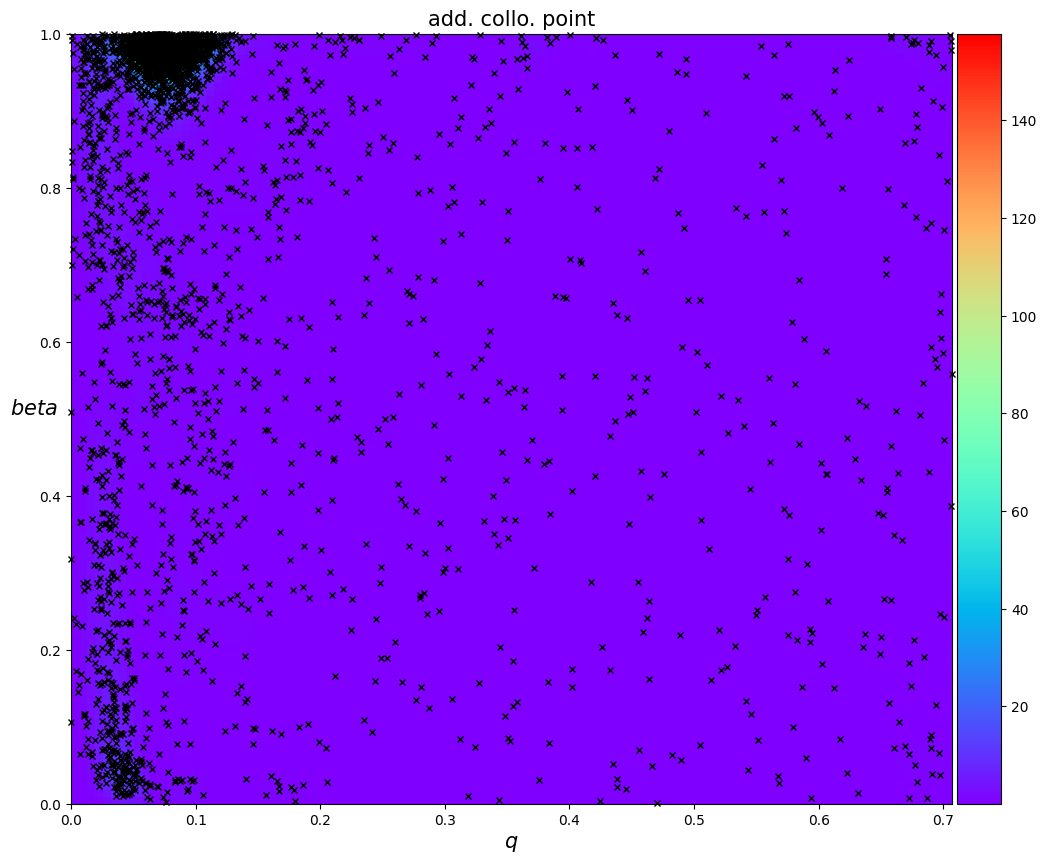

Step: 48100 | Loss: 4.6266e-12 | Loss_d: 3.1832e-14 | Loss_e: 3.5046e-11 | 
Step: 48200 | Loss: 4.2923e-12 | Loss_d: 1.3618e-14 | Loss_e: 3.1673e-11 | 
Step: 48300 | Loss: 4.1582e-12 | Loss_d: 9.8685e-14 | Loss_e: 2.9704e-11 | 
Step: 48400 | Loss: 4.2851e-12 | Loss_d: 9.9770e-14 | Loss_e: 3.2683e-11 | 
Step: 48500 | Loss: 4.2498e-12 | Loss_d: 3.5153e-14 | Loss_e: 3.0814e-11 | 
Step: 48600 | Loss: 4.1322e-12 | Loss_d: 1.3977e-14 | Loss_e: 3.0920e-11 | 
Step: 48700 | Loss: 4.1938e-12 | Loss_d: 1.6179e-13 | Loss_e: 3.1112e-11 | 
Step: 48800 | Loss: 3.9767e-12 | Loss_d: 2.2367e-14 | Loss_e: 2.8911e-11 | 
Step: 48900 | Loss: 4.5264e-12 | Loss_d: 2.8744e-13 | Loss_e: 3.0797e-11 | 
Step: 49000 | Loss: 4.1087e-12 | Loss_d: 2.0942e-14 | Loss_e: 3.1874e-11 | 
Step: 49100 | Loss: 4.1747e-12 | Loss_d: 2.6047e-14 | Loss_e: 3.0739e-11 | 
Step: 49200 | Loss: 4.3083e-12 | Loss_d: 1.1034e-13 | Loss_e: 3.2114e-11 | 
Step: 49300 | Loss: 4.1242e-12 | Loss_d: 8.4286e-14 | Loss_e: 2.9483e-11 | 
Step: 49400 

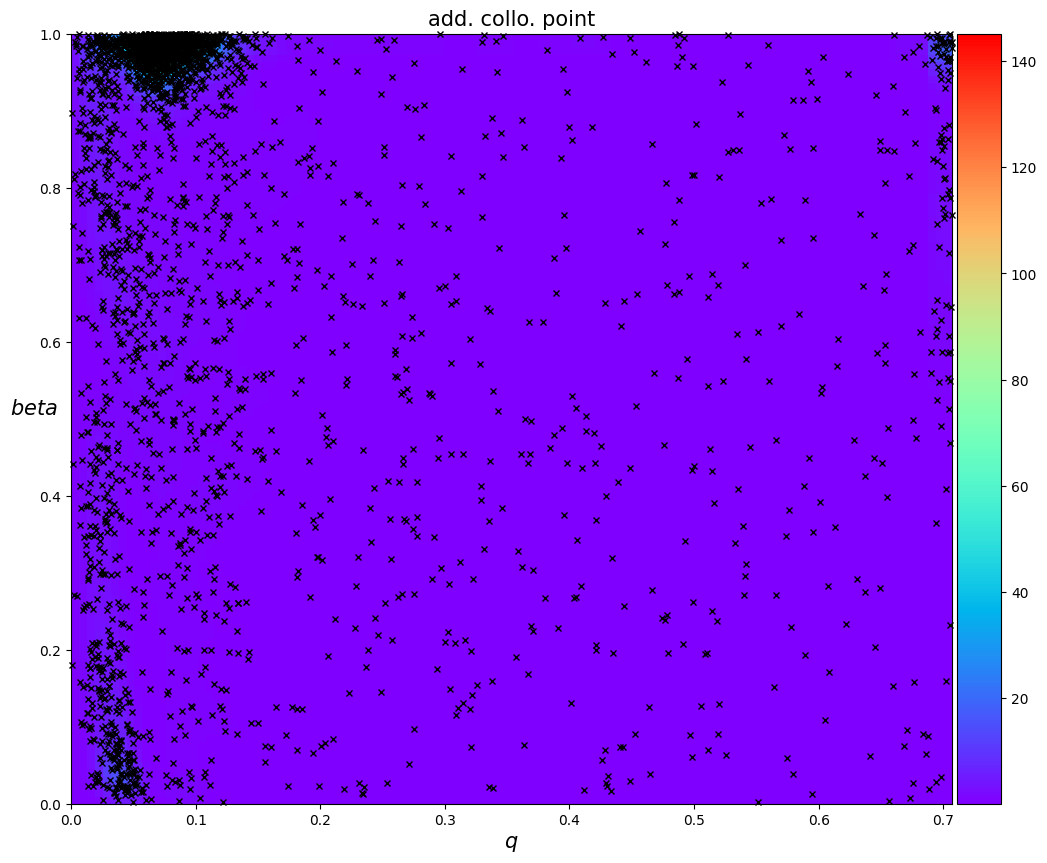

Step: 52100 | Loss: 4.0120e-12 | Loss_d: 2.3041e-14 | Loss_e: 3.1492e-11 | 
Step: 52200 | Loss: 3.6938e-12 | Loss_d: 1.3417e-14 | Loss_e: 2.7991e-11 | 
Step: 52300 | Loss: 3.6065e-12 | Loss_d: 1.1226e-14 | Loss_e: 2.5508e-11 | 
Step: 52400 | Loss: 3.6374e-12 | Loss_d: 1.2112e-14 | Loss_e: 2.6403e-11 | 
Step: 52500 | Loss: 3.4781e-12 | Loss_d: 1.1875e-14 | Loss_e: 2.5252e-11 | 
Step: 52600 | Loss: 3.6410e-12 | Loss_d: 2.0426e-14 | Loss_e: 2.5888e-11 | 
Step: 52700 | Loss: 3.5681e-12 | Loss_d: 4.3451e-14 | Loss_e: 2.6343e-11 | 
Step: 52800 | Loss: 3.8751e-12 | Loss_d: 3.3296e-13 | Loss_e: 2.4310e-11 | 
Step: 52900 | Loss: 3.4879e-12 | Loss_d: 2.6147e-14 | Loss_e: 2.5121e-11 | 
Step: 53000 | Loss: 3.9334e-12 | Loss_d: 2.1423e-13 | Loss_e: 3.0009e-11 | 
Step: 53100 | Loss: 3.5788e-12 | Loss_d: 3.0771e-14 | Loss_e: 2.6811e-11 | 
Step: 53200 | Loss: 3.4257e-12 | Loss_d: 1.5417e-14 | Loss_e: 2.4809e-11 | 
Step: 53300 | Loss: 3.4628e-12 | Loss_d: 5.5324e-14 | Loss_e: 2.4965e-11 | 
Step: 53400 

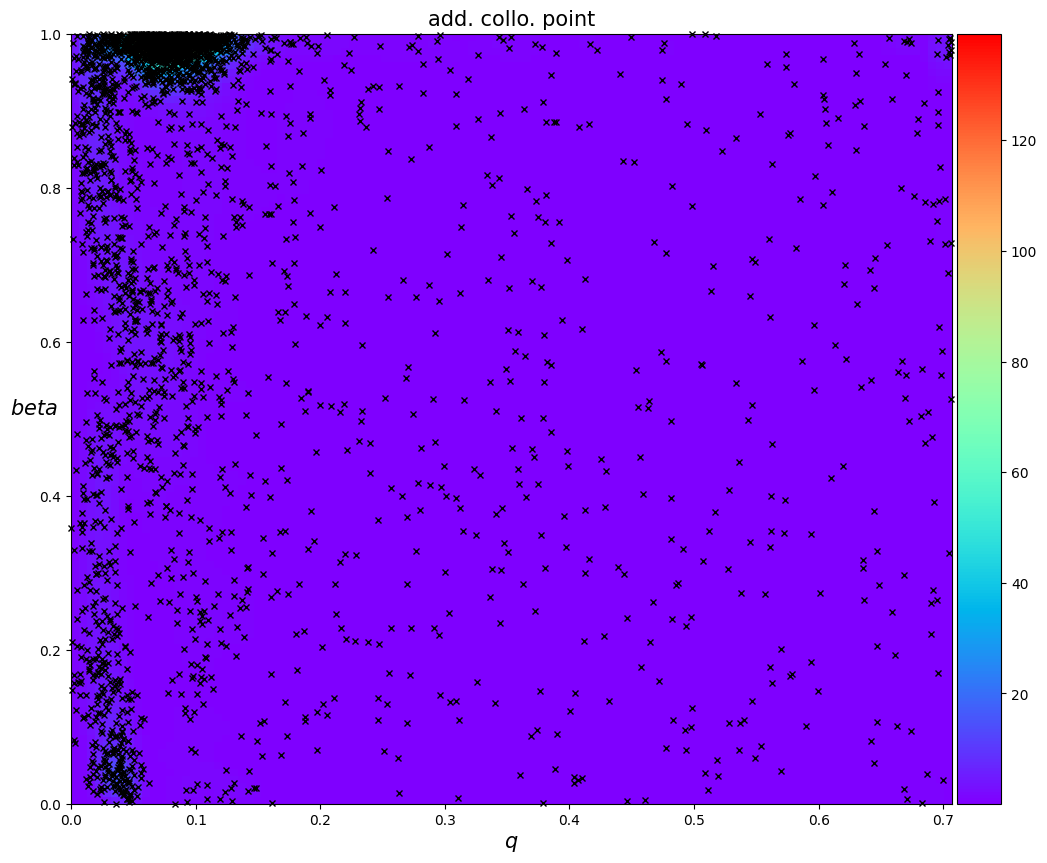

Step: 56100 | Loss: 3.4195e-12 | Loss_d: 9.9680e-15 | Loss_e: 2.6499e-11 | 
Step: 56200 | Loss: 3.2911e-12 | Loss_d: 9.7152e-15 | Loss_e: 2.4701e-11 | 
Step: 56300 | Loss: 3.2624e-12 | Loss_d: 1.0767e-14 | Loss_e: 2.3711e-11 | 
Step: 56400 | Loss: 3.0403e-12 | Loss_d: 1.3173e-14 | Loss_e: 2.2919e-11 | 
Step: 56500 | Loss: 3.1967e-12 | Loss_d: 4.0934e-14 | Loss_e: 2.3884e-11 | 
Step: 56600 | Loss: 3.1579e-12 | Loss_d: 7.5729e-14 | Loss_e: 2.2075e-11 | 
Step: 56700 | Loss: 3.0476e-12 | Loss_d: 1.1480e-14 | Loss_e: 2.2395e-11 | 
Step: 56800 | Loss: 3.1696e-12 | Loss_d: 4.8538e-14 | Loss_e: 2.2706e-11 | 
Step: 56900 | Loss: 3.0802e-12 | Loss_d: 2.9982e-14 | Loss_e: 2.2738e-11 | 
Step: 57000 | Loss: 2.9372e-12 | Loss_d: 9.7445e-15 | Loss_e: 2.2028e-11 | 
Step: 57100 | Loss: 3.0645e-12 | Loss_d: 1.1717e-14 | Loss_e: 2.3004e-11 | 
Step: 57200 | Loss: 4.3383e-12 | Loss_d: 1.1590e-12 | Loss_e: 2.3886e-11 | 
Step: 57300 | Loss: 3.6726e-12 | Loss_d: 1.5694e-13 | Loss_e: 2.9607e-11 | 
Step: 57400 

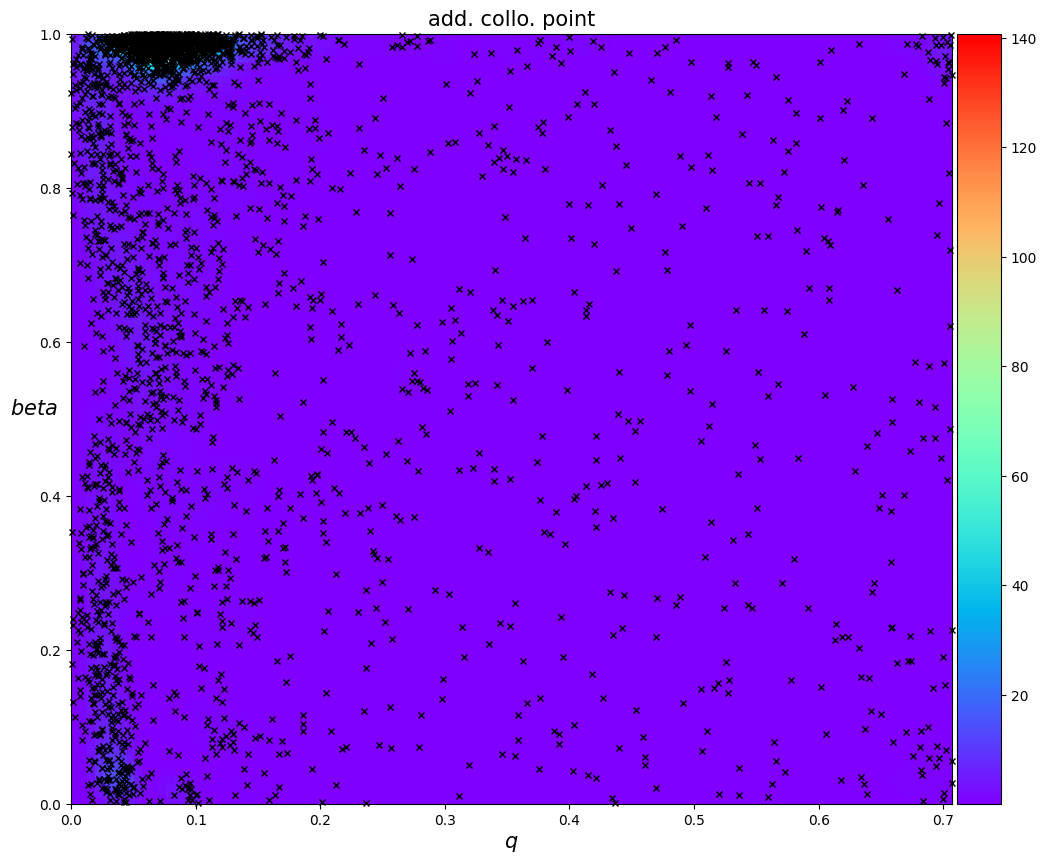

Step: 60100 | Loss: 2.8561e-12 | Loss_d: 9.6367e-15 | Loss_e: 2.1427e-11 | 
Step: 60200 | Loss: 2.7579e-12 | Loss_d: 2.7775e-14 | Loss_e: 2.1077e-11 | 
Step: 60300 | Loss: 3.0604e-12 | Loss_d: 7.8654e-14 | Loss_e: 2.4553e-11 | 
Step: 60400 | Loss: 3.0769e-12 | Loss_d: 2.0596e-13 | Loss_e: 2.4116e-11 | 
Step: 60500 | Loss: 3.4484e-12 | Loss_d: 6.5313e-13 | Loss_e: 2.1526e-11 | 
Step: 60600 | Loss: 2.8410e-12 | Loss_d: 4.5874e-14 | Loss_e: 2.2437e-11 | 
Step: 60700 | Loss: 3.1533e-12 | Loss_d: 1.5472e-13 | Loss_e: 2.4200e-11 | 
Step: 60800 | Loss: 2.7125e-12 | Loss_d: 3.8878e-14 | Loss_e: 2.0293e-11 | 
Step: 60900 | Loss: 2.9220e-12 | Loss_d: 2.6964e-13 | Loss_e: 2.0292e-11 | 
Step: 61000 | Loss: 2.6393e-12 | Loss_d: 2.0570e-14 | Loss_e: 1.9440e-11 | 
Step: 61100 | Loss: 2.6654e-12 | Loss_d: 1.0496e-13 | Loss_e: 1.9600e-11 | 
Step: 61200 | Loss: 2.7646e-12 | Loss_d: 6.6212e-14 | Loss_e: 2.0107e-11 | 
Step: 61300 | Loss: 2.6349e-12 | Loss_d: 3.4182e-14 | Loss_e: 2.0651e-11 | 
Step: 61400 

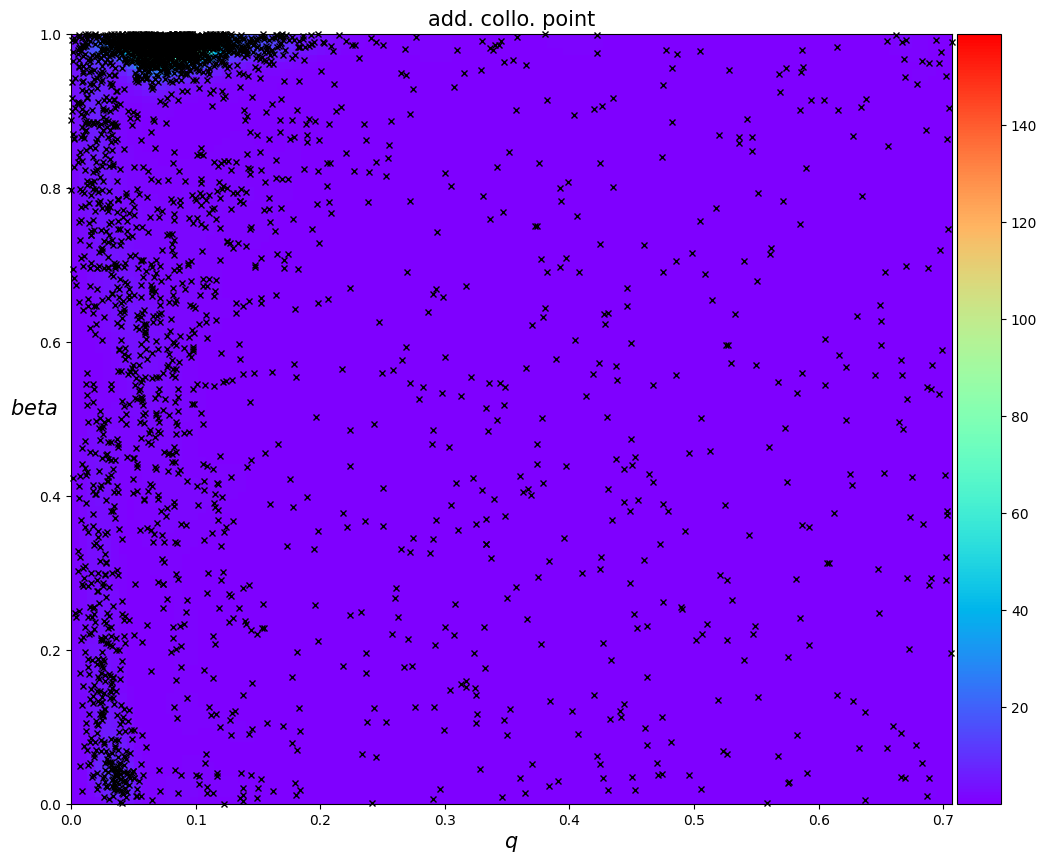

Step: 64100 | Loss: 2.7613e-12 | Loss_d: 2.4112e-14 | Loss_e: 2.0549e-11 | 
Step: 64200 | Loss: 2.3390e-12 | Loss_d: 9.2863e-15 | Loss_e: 1.6935e-11 | 
Step: 64300 | Loss: 2.2289e-12 | Loss_d: 8.5298e-15 | Loss_e: 1.7174e-11 | 
Step: 64400 | Loss: 2.2504e-12 | Loss_d: 9.3576e-15 | Loss_e: 1.6121e-11 | 
Step: 64500 | Loss: 2.2418e-12 | Loss_d: 7.4856e-15 | Loss_e: 1.6739e-11 | 
Step: 64600 | Loss: 2.3977e-12 | Loss_d: 1.7774e-13 | Loss_e: 1.7155e-11 | 
Step: 64700 | Loss: 2.8354e-12 | Loss_d: 5.7630e-13 | Loss_e: 1.7108e-11 | 
Step: 64800 | Loss: 4.8135e-12 | Loss_d: 2.3523e-12 | Loss_e: 1.9134e-11 | 
Step: 64900 | Loss: 2.6687e-12 | Loss_d: 8.4444e-14 | Loss_e: 2.1171e-11 | 
Step: 65000 | Loss: 2.2559e-12 | Loss_d: 4.8129e-14 | Loss_e: 1.7416e-11 | 
Step: 65100 | Loss: 2.1557e-12 | Loss_d: 6.9198e-15 | Loss_e: 1.6932e-11 | 
Step: 65200 | Loss: 2.1685e-12 | Loss_d: 4.1674e-14 | Loss_e: 1.5953e-11 | 
Step: 65300 | Loss: 2.2050e-12 | Loss_d: 3.4199e-14 | Loss_e: 1.7911e-11 | 
Step: 65400 

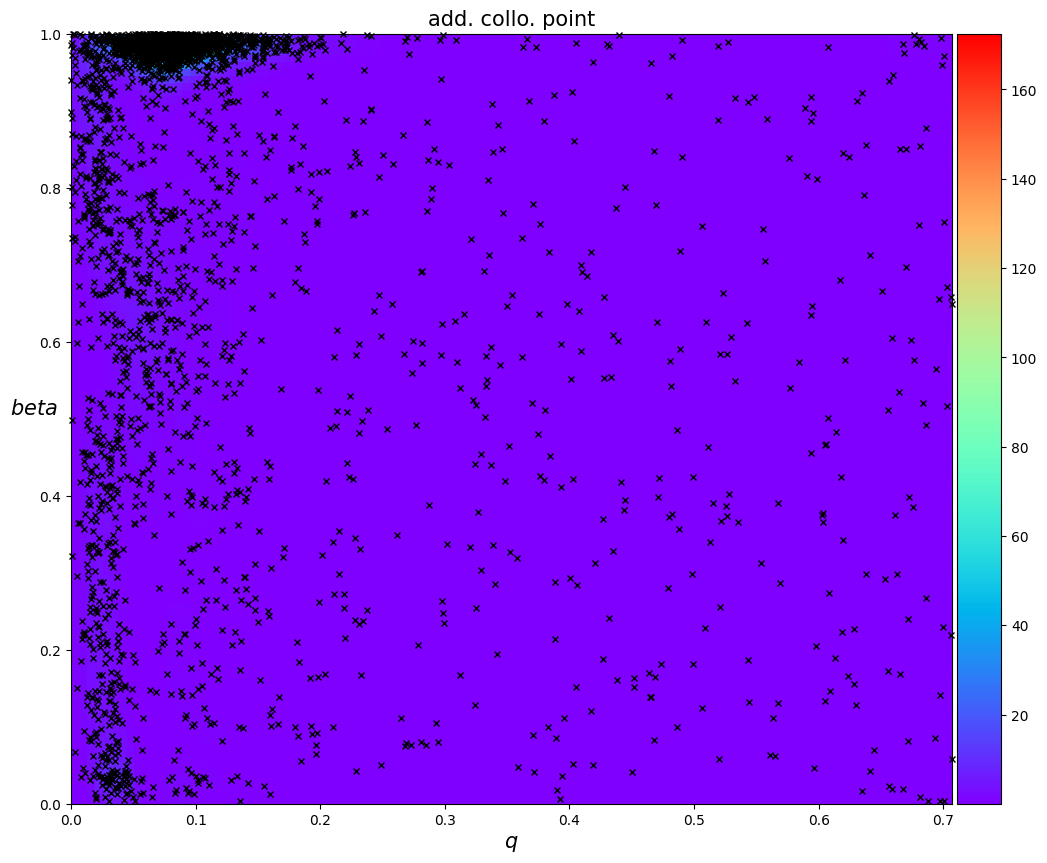

Step: 68100 | Loss: 2.6734e-12 | Loss_d: 2.5351e-13 | Loss_e: 2.0019e-11 | 
Step: 68200 | Loss: 2.0322e-12 | Loss_d: 1.4382e-14 | Loss_e: 1.5416e-11 | 
Step: 68300 | Loss: 1.8305e-12 | Loss_d: 8.0096e-15 | Loss_e: 1.3920e-11 | 
Step: 68400 | Loss: 2.0073e-12 | Loss_d: 1.2201e-13 | Loss_e: 1.3353e-11 | 
Step: 68500 | Loss: 1.9969e-12 | Loss_d: 8.3620e-14 | Loss_e: 1.3619e-11 | 
Step: 68600 | Loss: 1.8660e-12 | Loss_d: 2.5118e-14 | Loss_e: 1.4818e-11 | 
Step: 68700 | Loss: 1.9966e-12 | Loss_d: 2.4662e-14 | Loss_e: 1.5737e-11 | 
Step: 68800 | Loss: 1.8473e-12 | Loss_d: 6.3040e-15 | Loss_e: 1.4332e-11 | 
Step: 68900 | Loss: 1.8533e-12 | Loss_d: 1.0891e-14 | Loss_e: 1.4261e-11 | 
Step: 69000 | Loss: 1.8507e-12 | Loss_d: 6.9239e-15 | Loss_e: 1.3996e-11 | 
Step: 69100 | Loss: 2.7266e-12 | Loss_d: 8.7070e-13 | Loss_e: 1.4163e-11 | 
Step: 69200 | Loss: 1.7960e-12 | Loss_d: 1.3634e-14 | Loss_e: 1.3787e-11 | 
Step: 69300 | Loss: 1.8411e-12 | Loss_d: 2.2429e-14 | Loss_e: 1.4268e-11 | 
Step: 69400 

In [ ]:
"""Training using Adam"""

# set the learning rate for Adam
lr = 1e-3
epoch1 = 70000
trained_params2, loss21 = adam_optimizer(Q, BETA, NN_loss, pred_u2, trained_params2, dataf2, Fs, epoch1, lr=lr)
Fs = predictF(pred_u2, trained_params2, Q, BETA)
data2 = dataf2(key_lbfgs[8], Fs, Q, BETA)

In [ ]:
"""Training using L-BFGS"""

loss22 = []
epoch2 = 15000
for l in range(3):
    trained_params2, loss = lbfgs_optimizer(NN_loss, trained_params2, data2, epoch2)
    Fs = predictF(pred_u2, trained_params2, Q, BETA)
    data2 = dataf2(key_lbfgs[9], Fs, Q, BETA)
    loss22 += loss

流式输出内容被截断，只能显示最后 5000 行内容。
Step: NaN | Loss: 7.7388e-14 | Loss_d: 1.4666e-15 | Loss_e: 9.4074e-13
Step: NaN | Loss: 7.7385e-14 | Loss_d: 1.4656e-15 | Loss_e: 9.4072e-13
Step: NaN | Loss: 7.7382e-14 | Loss_d: 1.4650e-15 | Loss_e: 9.4065e-13
Step: NaN | Loss: 7.7382e-14 | Loss_d: 1.4647e-15 | Loss_e: 9.4066e-13
Step: NaN | Loss: 7.7380e-14 | Loss_d: 1.4651e-15 | Loss_e: 9.4065e-13
Step: NaN | Loss: 7.7402e-14 | Loss_d: 1.4726e-15 | Loss_e: 9.4091e-13
Step: NaN | Loss: 7.7380e-14 | Loss_d: 1.4652e-15 | Loss_e: 9.4065e-13
Step: NaN | Loss: 7.7379e-14 | Loss_d: 1.4640e-15 | Loss_e: 9.4065e-13
Step: NaN | Loss: 7.7382e-14 | Loss_d: 1.4654e-15 | Loss_e: 9.4068e-13
Step: NaN | Loss: 7.7378e-14 | Loss_d: 1.4634e-15 | Loss_e: 9.4065e-13
Step: NaN | Loss: 7.7383e-14 | Loss_d: 1.4670e-15 | Loss_e: 9.4062e-13
Step: NaN | Loss: 7.7378e-14 | Loss_d: 1.4633e-15 | Loss_e: 9.4064e-13
Step: NaN | Loss: 7.7378e-14 | Loss_d: 1.4632e-15 | Loss_e: 9.4064e-13
Step: NaN | Loss: 7.7377e-14 | Loss_d: 1.4626e-15 

#Result of 2nd stage

In [ ]:
"""Solution of stage 2"""

# calculate the equation residue
f_u2 = lambda z: pred_u2(trained_params2, z)

# calculate the solution
u_p2 = f_u2(X_star)
f_p2 = gov_eqn(f_u2, X_star)[0]

U2 = jnp.reshape(u_p2[:, 0:1], X.shape)
V2 = jnp.reshape(u_p2[:, 1:2], X.shape)
F2 = jnp.reshape(f_p2, X.shape)

# generate the last loss
loss_all2 = np.array(loss21 + loss22)
loss_all = np.vstack([loss_all1, loss_all2])

# generate results within [-10,10]
x_fin = jnp.linspace(-10.0, 10.0, 111)
y_fin = jnp.linspace(-10.0, 10.0, 111)

X_fin, Y_fin = jnp.meshgrid(x_fin, y_fin)
X_star_fin = jnp.hstack((X_fin.flatten()[:, None], Y_fin.flatten()[:, None]))
u2_fin = f_u2(X_star_fin)[:, 0:1]
v2_fin = f_u2(X_star_fin)[:, 1:2]
f_p2_fin = gov_eqn(f_u2, X_star_fin)[0]

mask_star_fin = (X_fin ** 2 + Y_fin ** 2 < 1)
F2_fin = jnp.where(mask_star_fin, jnp.nan, jnp.reshape(f_p2_fin, X_fin.shape))
U2_fin = jnp.where(mask_star_fin, jnp.nan, jnp.reshape(u2_fin, X_fin.shape))
V2_fin = jnp.where(mask_star_fin, jnp.nan, jnp.reshape(v2_fin, X_fin.shape))

In [ ]:
mdic = {'X': np.array(X), 'Y': np.array(Y), 'U2': np.array(U2), 'V2': np.array(V2),
        "F2": np.array(F2), 'X_fin': np.array(X_fin), 'Y_fin': np.array(Y_fin),
        'U2_fin': np.array(U2_fin), 'V2_fin': np.array(V2_fin), "F2_fin": np.array(F2_fin), "loss": loss_all}

FileName = f'2nd_Stage_Nonlinear_UV_Transfer_Coordinate_Circle_results.mat'

# save the data to Google Drive
FilePath = str(rootdir.joinpath(FileName))
savemat(FilePath, mdic)

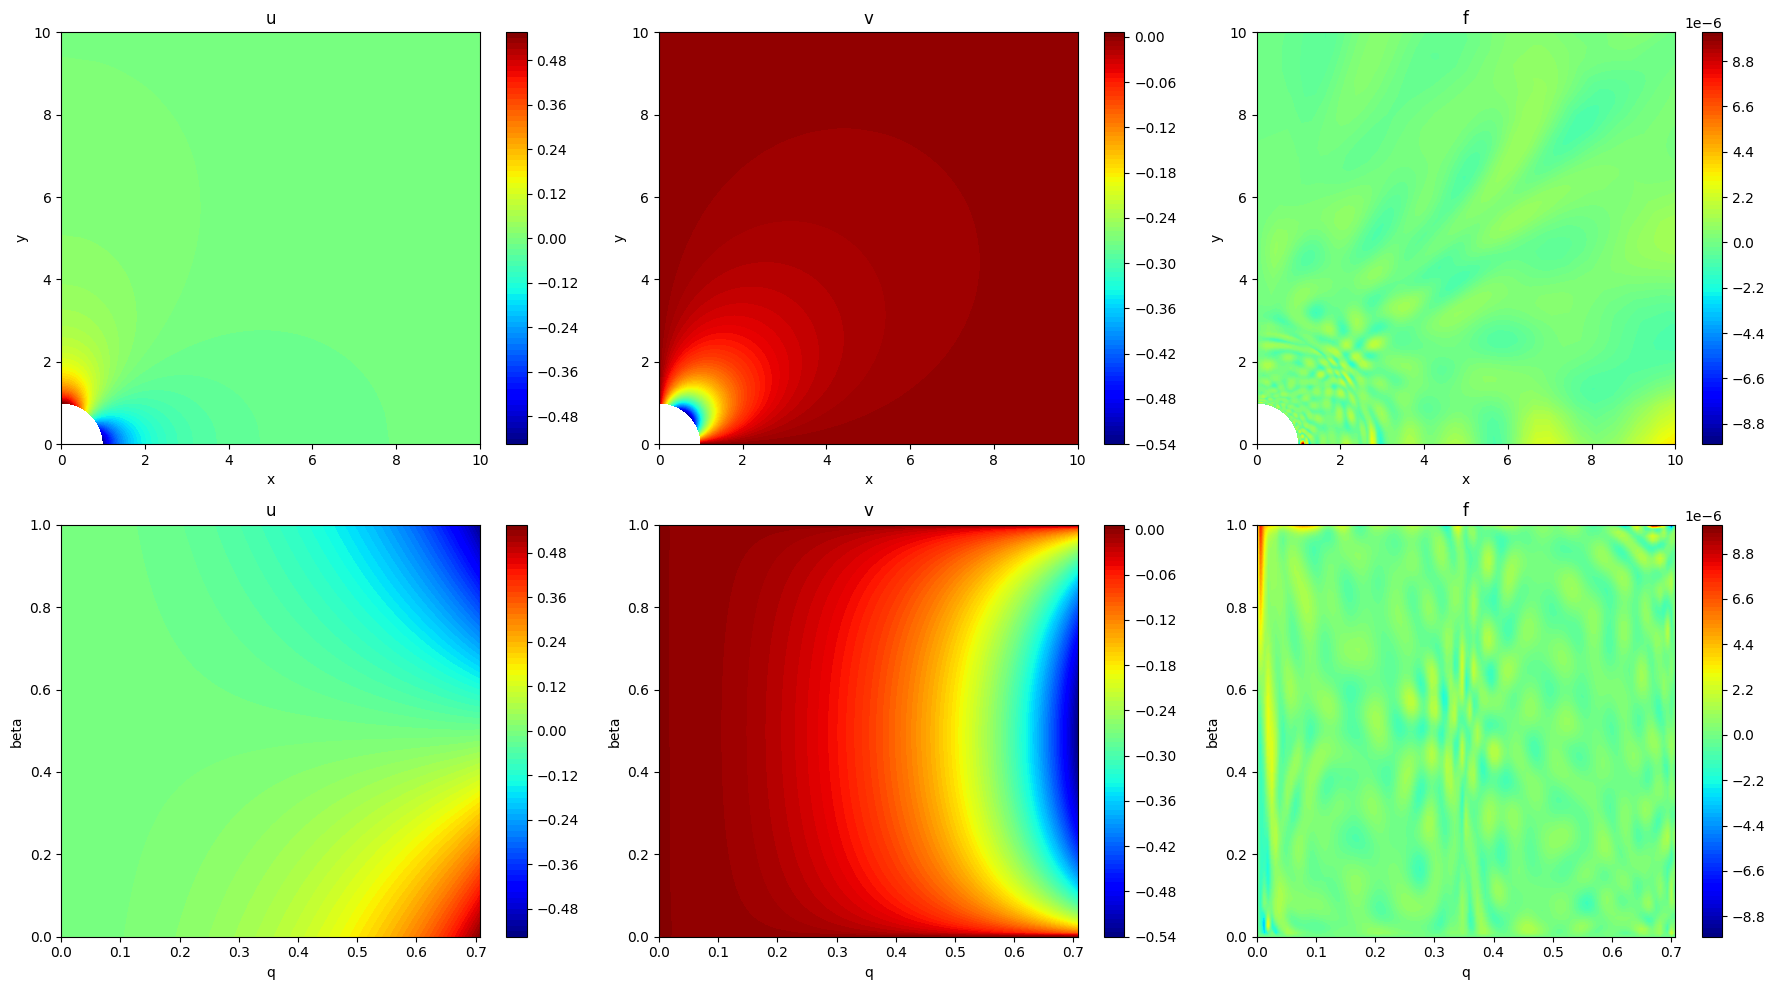

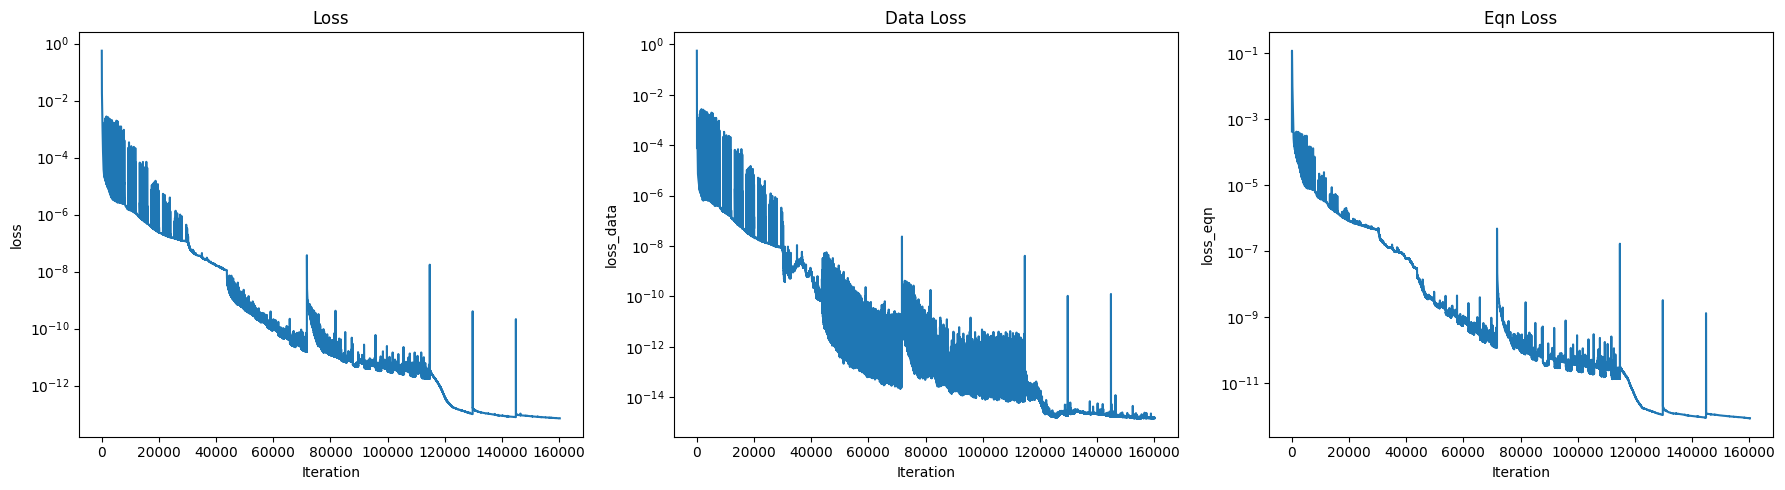

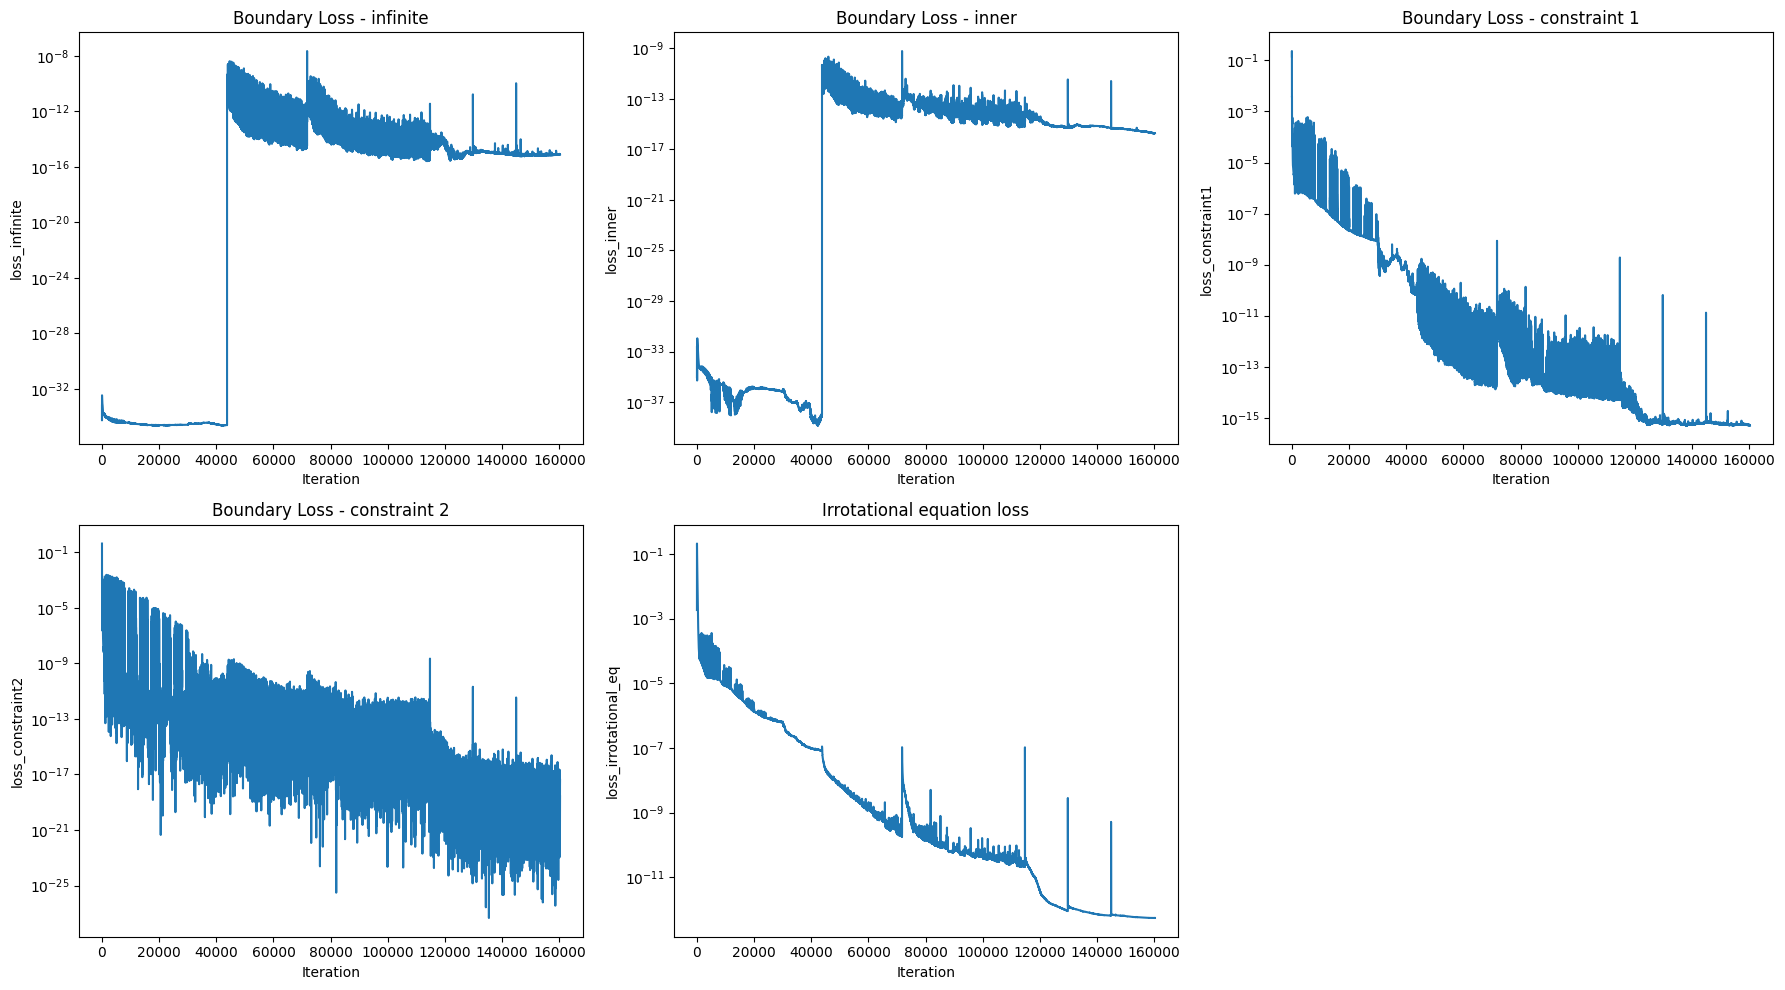

In [ ]:
"""Figure 1 - Result"""
fig1 = plt.figure(figsize=(18, 10))

ax1 = plt.subplot(231)
contour1 = ax1.contourf(X, Y, U2, 100, cmap='jet')
fig1.colorbar(contour1, ax=ax1)
ax1.set_title('u')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(0,10)
ax1.set_ylim(0,10)

ax2 = plt.subplot(232)
contour2 = ax2.contourf(X, Y, V2, 100, cmap='jet')
fig1.colorbar(contour2, ax=ax2)
ax2.set_title('v')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xlim(0,10)
ax2.set_ylim(0,10)

ax3 = plt.subplot(233)
contour3 = ax3.contourf(X, Y, F2, 100, cmap='jet')
fig1.colorbar(contour3, ax=ax3)
ax3.set_title('f')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_xlim(0,10)
ax3.set_ylim(0,10)

ax4 = plt.subplot(234)
contour4 = ax4.contourf(Q, BETA, U2, 100, cmap='jet')
fig1.colorbar(contour4, ax=ax4)
ax4.set_title('u')
ax4.set_xlabel('q')
ax4.set_ylabel('beta')

ax5 = plt.subplot(235)
contour5 = ax5.contourf(Q, BETA, V2, 100, cmap='jet')
fig1.colorbar(contour5, ax=ax5)
ax5.set_title('v')
ax5.set_xlabel('q')
ax5.set_ylabel('beta')

ax6 = plt.subplot(236)
contour6 = ax6.contourf(Q, BETA, F2, 100, cmap='jet')
fig1.colorbar(contour6, ax=ax6)
ax6.set_title('f')
ax6.set_xlabel('q')
ax6.set_ylabel('beta')

plt.tight_layout()
plt.show()

"""Figure 2 - Loss_d + Loss_e"""
fig2 = plt.figure(figsize=(18, 5))

# subplot - loss
ax1 = plt.subplot(131)
ax1.plot(range(len(loss_all)), loss_all[:, 0])
ax1.set_yscale('log')
ax1.set_title('Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('loss')

# subplot - loss_data
ax2 = plt.subplot(132)
ax2.plot(range(len(loss_all)), loss_all[:, 1])
ax2.set_yscale('log')
ax2.set_title('Data Loss')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('loss_data')

# subplot - loss_eqn
ax3 = plt.subplot(133)
ax3.plot(range(len(loss_all)), loss_all[:, -1])
ax3.set_yscale('log')
ax3.set_title('Eqn Loss')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('loss_eqn')

plt.tight_layout()
plt.show()

"""Figure 4 - Loss_d + Loss_e (specific)"""
fig3 = plt.figure(figsize=(18, 10))

# subplot - boundary loss - xy_inf
ax1 = plt.subplot(231)
ax1.plot(range(len(loss_all)), loss_all[:, 3])
ax1.set_yscale('log')
ax1.set_title('Boundary Loss - infinite')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('loss_infinite')

# subplot - boundary loss - xy_inner
ax2 = plt.subplot(232)
ax2.plot(range(len(loss_all)), loss_all[:, 4])
ax2.set_yscale('log')
ax2.set_title('Boundary Loss - inner')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('loss_inner')

# subplot - boundary loss - constraint 1
ax3 = plt.subplot(233)
ax3.plot(range(len(loss_all)), loss_all[:, 5])
ax3.set_yscale('log')
ax3.set_title('Boundary Loss - constraint 1')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('loss_constraint1')

# subplot - boundary loss - constraint 2
ax4 = plt.subplot(234)
ax4.plot(range(len(loss_all)), loss_all[:, 6])
ax4.set_yscale('log')
ax4.set_title('Boundary Loss - constraint 2')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('loss_constraint2')

# subplot - boundary loss - irrotational equation loss
ax4 = plt.subplot(235)
ax4.plot(range(len(loss_all)), loss_all[:, -2])
ax4.set_yscale('log')
ax4.set_title('Irrotational equation loss')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('loss_irrotational_eq')

plt.tight_layout()
plt.show()

In [ ]:
"""RMS for equation and solution error"""
r2_rms = ms_error(f_p2) ** 0.5
print('r2=', r2_rms)

r2= [6.67148766e-07]


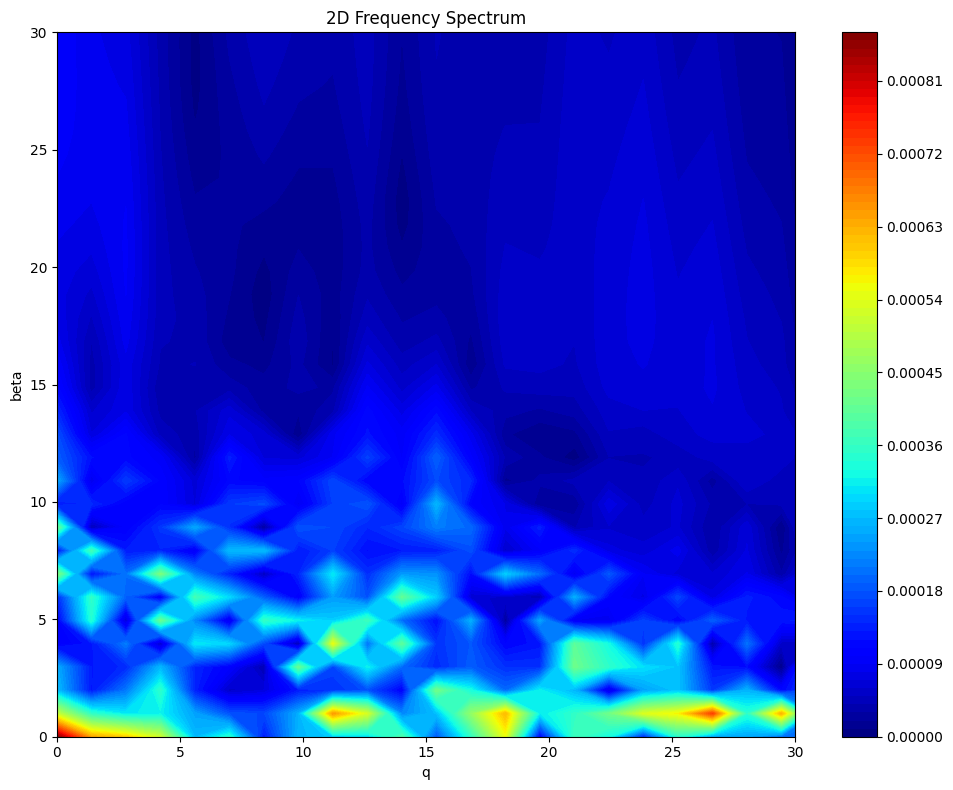

In [ ]:
from scipy.fftpack import fft2, fftshift, fftfreq

# Perform FFT on F2 in (q, beta) domain
F2_np = np.array(F2)
F2_fft = fftshift(fft2(F2_np))
magnitude = np.abs(F2_fft)

# Frequency axes
dq = q[1] - q[0]
db = beta[1] - beta[0]
freq_q = fftshift(fftfreq(len(q), d=dq))
freq_beta = fftshift(fftfreq(len(beta), d=db))

# Plot the frequency spectrum
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(freq_q, freq_beta, np.log1p(magnitude), 100, cmap='jet')
fig.colorbar(contour, ax=ax)
ax.set_title("2D Frequency Spectrum")
ax.set_xlabel("q")
ax.set_ylabel("beta")
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
plt.tight_layout()